# Show samples on frequency domain

This notebook will show all the samples per dataset and class on frequency domain.

1. Apply DFT over dataset windows
2. Calculate mean, 25 percentil, and 75 percentil samples
3. Plot the mean like line and 25/75 percentil like enveloping

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import ExtraSensorySenseUnbalancedResampledView20HZ, UCIHARUnbalancedView, WISDMInterpolatedUnbalancedView, KuHarResampledView20HZ, MotionSenseResampledView20HZ, CHARMUnbalancedView

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms. stats import StatsTransform
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-05 01:59:06.590112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-05 01:59:06.590132: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load ExtraSensory

In [3]:
# Load ExtraSensory, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = ExtraSensorySenseUnbalancedResampledView20HZ("../../../data/views/ExtraSensory/unbalanced_train_only_resampled_20hz", download=False)
train_val_es = loader.load()[0]

In [4]:
# Resampling the dataset to 20 Hz
resampler = SimpleResampler(new_sample_size=60)
transformer = TransformMultiModalDataset(
    transforms=[resampler], new_window_name_prefix="resampled."
)

train_val_es = transformer(train_val_es)


extrasensory_X = train_val_es.X
extrasensory_Y = train_val_es.y
tam = len(extrasensory_Y)
extrasensory_id_dataset = np.array(['E']*tam)

In [5]:
np.unique(train_val_es.y)

array([0, 1, 2, 3])

## Load UCI-HAR

In [6]:
# Load UCI-HAR, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHARUnbalancedView("../../../data/views/UCI-HAR/unbalanced_view_train_test-v1", download=False)
train_val_uci, test_uci = loader.load(concat_train_validation=True)
train_val_uci.data['activity code'] = train_val_uci.data['activity code'].astype('int')

In [7]:
train_val_uci.data = train_val_uci.data[train_val_uci.data['activity code'].isin([0, 1, 2, 3, 4, 5])]
train_val_uci.data

accel-x-0  accel-x-1  accel-x-2  accel-x-3  accel-x-4  accel-x-5  \
0      0.000181   0.010139   0.009276   0.005066   0.010810   0.004045   
1      0.002156   0.000478  -0.001506  -0.002105  -0.001494   0.002181   
2     -0.000898  -0.001478  -0.000698   0.000441  -0.001206  -0.002607   
3      0.004896   0.003659   0.001017  -0.000353  -0.002137  -0.004167   
4     -0.000841  -0.000967  -0.000631   0.001149   0.002415   0.001951   
...         ...        ...        ...        ...        ...        ...   
3044  -0.031849  -0.009764  -0.068084  -0.049961   0.014943   0.064865   
3045   0.088233   0.094266   0.140152   0.217359   0.318959   0.445108   
3046   0.215947   0.251700   0.365916   0.522914   0.550868   0.519728   
3047  -0.068505  -0.163113  -0.298020  -0.377107  -0.390136  -0.327854   
3048  -0.150869  -0.132237  -0.068338   0.007874   0.096481   0.205834   

      accel-x-6  accel-x-7  accel-x-8  accel-x-9  ...  gyro-z-142  gyro-z-143  \
0      0.004757   0.006214   0.003307   0.007572  ...    0.002408    0.002692   
1      0.002876   0.000871  -0.000392  -0.000569  ...   -0.009789   -0.008616   
2     -0.001986  -0.001230  -0.001129  -0.001334  ...    0.001686    0.000255   
3     -0.003278   0.000543   0.002926   0.001613  ...   -0.001083    0.001856   
4      0.001021   0.001290   0.002354   0.001780  ...   -0.000121    0.002688   
...         ...        ...        ...        ...  ...         ...         ...   
3044   0.069712   0.028482   0.049309   0.065892  ...   -0.780938   -0.677853   
3045   0.523727   0.499570   0.431694   0.340760  ...   -0.402766   -0.248852   
3046   0.483533   0.361677   0.203005   0.114670  ...    0.281919    0.232009   
3047  -0.241962  -0.217053  -0.212419  -0.222440  ...    0.137811    0.068896   
3048   0.441342   0.662930   0.516996   0.163970  ...   -0.433917   -0.666168   

      gyro-z-144  gyro-z-145  gyro-z-146  gyro-z-147  gyro-z-148  gyro-z-149  \
0       0.007057    0.010491    0.011465    0.007355    0.000958   -0.005727   
1      -0.008832   -0.001896    0.001873   -0.001333   -0.002344   -0.001665   
2       0.003125    0.009727    0.017903    0.024423    0.017171    0.008785   
3       0.002373   -0.001953   -0.006491   -0.010222   -0.012760   -0.010986   
4       0.002410    0.002005    0.005585    0.006213    0.005733    0.003912   
...          ...         ...         ...         ...         ...         ...   
3044   -0.563571   -0.480737   -0.358611   -0.252444   -0.199429   -0.183848   
3045   -0.133263    0.009732    0.108254    0.147027    0.167305    0.218834   
3046    0.187022    0.069915    0.133291    0.274027    0.368733    0.464738   
3047    0.061847    0.105364    0.192774    0.251018    0.300847    0.351178   
3048   -0.803212   -0.814059   -0.751147   -0.698217   -0.649626   -0.647913   

      activity code  user  
0                 5     1  
1                 5     1  
2                 5     1  
3                 5     1  
4                 5     1  
...             ...   ...  
3044              2    30  
3045              2    30  
3046              2    30  
3047              2    30  
3048              2    30  

[2459 rows x 902 columns]

In [8]:
train_val_uci = transformer(train_val_uci)
test_uci = transformer(test_uci)
# train_uci = pd.DataFrame(train_val_uci.X)
uci_X = train_val_uci.X
uci_Y = train_val_uci.y

tam = len(uci_Y)
uci_id_dataset = np.array(['U']*tam)

## Load WISDM

In [9]:
# Load WISDM and create PandasMultiModalDatasets with the correct pre-defined windows
loader = WISDMInterpolatedUnbalancedView("../../../data/views/WISDM/interpolated_unbalanced_view_train_test-v1", download=False)
train_val_wisdm, test_wisdm = loader.load(concat_train_validation=True)

#rename "activity" with "activity code"
train_val_wisdm.data.rename(columns = {'activity':'activity code'}, inplace = True)
#test.data.rename(columns = {'activity':'activity code'}, inplace = True)

train_val_wisdm.data['activity code'] = train_val_wisdm.data['activity code'].astype('int')

In [10]:
wisdm_X = np.array(train_val_wisdm.data.iloc[:,:-2])
wisdm_Y = np.array(train_val_wisdm.data['activity code'])

tam = len(wisdm_Y)
wisdm_id_dataset = np.array(['W']*tam)

## Load KuHar

In [11]:
loader = KuHarResampledView20HZ("../../../../data/views/KuHar/balanced_motionsense_equivalent_resampled_view_20Hz")

In [12]:
train_val_kh, test_kh = loader.load(concat_train_validation=True)

In [13]:
train_val_kh.data

Unnamed: 0  accel-x-0  accel-x-1  accel-x-2  accel-x-3  accel-x-4  \
0              0  -1.042828   7.069610   3.455672   0.858443 -13.806092   
1              1  -2.437900  -2.628449  -2.166861  -3.854701   0.527599   
2              2  -0.664337   0.483465   3.090238   3.559119   3.888318   
3              3  -2.269775  -3.209509  -2.508545  -2.923223  -1.269270   
4              4  -0.487718   0.226401   0.609332   1.490074  -0.295221   
...          ...        ...        ...        ...        ...        ...   
3109         199 -16.047706 -10.232285  -1.393564  22.982999  13.706479   
3110         200   1.911780  -6.910686   1.625745  12.975344  12.066726   
3111         201   3.927244  19.311380   0.403673 -14.236972 -10.454149   
3112         202  -7.208894 -11.734247  13.677432  21.571222   3.191808   
3113         203  -1.305200   0.776255  -2.010409   1.391518  -0.178828   

      accel-x-5  accel-x-6  accel-x-7  accel-x-8  ...  accel-start-time  \
0     -5.950121  -0.608514   2.916913   4.881929  ...             9.159   
1     11.567884   6.840191  -2.435600  -3.324599  ...             9.167   
2      1.113559   3.656104   4.866379   0.073993  ...            15.262   
3      7.864898   7.683389   2.325797  -3.086381  ...            33.572   
4     -1.111420  -0.627382   0.028419  -0.823724  ...             0.008   
...         ...        ...        ...        ...  ...               ...   
3109   7.789294  -4.720361 -15.633462  -8.674399  ...             3.000   
3110   5.300426 -10.848059 -14.261385  -3.988711  ...             5.927   
3111  -4.218160  -4.307016  17.655546  12.570647  ...             2.966   
3112   2.215446 -12.397302 -13.905091  -8.743007  ...             3.003   
3113  -0.231716  -1.165479  -0.072946  -2.452232  ...             0.010   

      gyro-start-time  accel-end-time  gyro-end-time  activity code  length  \
0               9.160          12.199         12.201              0     300   
1               9.166          12.211         12.208              0     300   
2              15.263          18.298         18.299              0     300   
3              33.583          36.615         36.626              0     300   
4               0.007           3.047          3.048              0     300   
...               ...             ...            ...            ...     ...   
3109            3.007           6.000          6.008              5     300   
3110            5.927           8.880          8.879              5     300   
3111            2.966           5.920          5.919              5     300   
3112            3.001           5.993          5.991              5     300   
3113            0.008           3.000          2.998              5     300   

      serial  index  user  normalized activity code  
0         23    900  1101                         4  
1         43    900  1101                         4  
2         24   1500  1101                         4  
3         41   3300  1101                         4  
4         30      0  1101                         4  
...      ...    ...   ...                       ...  
3109       8    300  1042                         5  
3110       2    600  1046                         5  
3111       5    300  1046                         5  
3112       6    300  1042                         5  
3113       7      0  1042                         5  

[3114 rows x 371 columns]

In [14]:
train_val_kh.data['normalized activity code'].unique()

array([4, 3, 0, 1, 2, 5])

In [15]:
train_val_kh.data.iloc[:,1:-10]

accel-x-0  accel-x-1  accel-x-2  accel-x-3  accel-x-4  accel-x-5  \
0     -1.042828   7.069610   3.455672   0.858443 -13.806092  -5.950121   
1     -2.437900  -2.628449  -2.166861  -3.854701   0.527599  11.567884   
2     -0.664337   0.483465   3.090238   3.559119   3.888318   1.113559   
3     -2.269775  -3.209509  -2.508545  -2.923223  -1.269270   7.864898   
4     -0.487718   0.226401   0.609332   1.490074  -0.295221  -1.111420   
...         ...        ...        ...        ...        ...        ...   
3109 -16.047706 -10.232285  -1.393564  22.982999  13.706479   7.789294   
3110   1.911780  -6.910686   1.625745  12.975344  12.066726   5.300426   
3111   3.927244  19.311380   0.403673 -14.236972 -10.454149  -4.218160   
3112  -7.208894 -11.734247  13.677432  21.571222   3.191808   2.215446   
3113  -1.305200   0.776255  -2.010409   1.391518  -0.178828  -0.231716   

      accel-x-6  accel-x-7  accel-x-8  accel-x-9  ...  gyro-z-50  gyro-z-51  \
0     -0.608514   2.916913   4.881929   8.610287  ...  -0.472805   0.343294   
1      6.840191  -2.435600  -3.324599  -0.796095  ...   0.267483  -0.713088   
2      3.656104   4.866379   0.073993 -14.136122  ...   0.371043   0.478258   
3      7.683389   2.325797  -3.086381  -3.675483  ...   0.011855   0.110627   
4     -0.627382   0.028419  -0.823724  -0.469242  ...  -0.224966   0.039142   
...         ...        ...        ...        ...  ...        ...        ...   
3109  -4.720361 -15.633462  -8.674399 -11.634360  ...  -0.110008   1.042713   
3110 -10.848059 -14.261385  -3.988711  -4.235381  ...  -0.255121   0.348626   
3111  -4.307016  17.655546  12.570647   7.031853  ...  -0.825732  -0.816069   
3112 -12.397302 -13.905091  -8.743007  11.580156  ...   0.261531   1.145154   
3113  -1.165479  -0.072946  -2.452232  -0.006160  ...  -2.575965   0.656680   

      gyro-z-52  gyro-z-53  gyro-z-54  gyro-z-55  gyro-z-56  gyro-z-57  \
0      0.260441  -0.082865   0.299246   0.215924   0.322555   0.508903   
1      0.337778  -0.016247  -0.170998   0.067450  -0.153206  -0.094137   
2     -0.547497  -0.010739   0.005712  -0.275884   0.048012   0.288451   
3      0.131676   0.085040   0.143971   0.129493   0.189543   0.057577   
4     -0.232840   0.027406  -0.153478  -0.047371   0.020793   0.186724   
...         ...        ...        ...        ...        ...        ...   
3109  -1.098746  -0.203113   0.062445   0.489244  -0.153889  -0.825626   
3110   1.796430  -0.504031  -0.271142  -0.141103  -0.355877   0.450288   
3111  -0.332729  -0.034519   0.551195  -0.635052  -1.169866   0.926100   
3112  -0.355114   1.075646  -1.983060  -1.722173   2.191585  -0.139135   
3113   1.097035  -0.342955   0.857094   0.416067  -1.078520   0.539480   

      gyro-z-58  gyro-z-59  
0     -0.113054  -0.380190  
1     -0.238300   0.377260  
2      0.118925   0.288595  
3     -0.121568  -0.037776  
4      0.132858   0.318369  
...         ...        ...  
3109   1.408920  -0.048886  
3110  -0.041400  -0.955341  
3111   1.036354  -0.090644  
3112   0.742427   0.765420  
3113   1.161192  -0.462714  

[3114 rows x 360 columns]

In [16]:
kuhar_X = np.array(train_val_kh.data.iloc[:,1:-10])
kuhar_Y = np.array(train_val_kh.data['normalized activity code'])
tam = len(kuhar_Y)
kuhar_id_dataset = np.array(['K']*tam)

## Load MotionSense

In [17]:
loader = MotionSenseResampledView20HZ("../../../../data/views/MotionSense/resampled_view_20Hz")

In [18]:
# Motionsense dataframe
train_val_motion, test_motion = loader.load(concat_train_validation=True)

In [19]:
train_val_motion.data.iloc[:,1:-6]

userAcceleration.x-0  userAcceleration.x-1  userAcceleration.x-2  \
0                -0.101581             -0.221355             -0.234016   
1                -0.082527              0.201136             -0.017408   
2                 0.108323             -0.045941              0.017410   
3                -0.370755             -0.495850              0.205895   
4                -0.005683              0.452370              0.028475   
...                    ...                   ...                   ...   
4015             -0.007693              0.374393             -0.103716   
4016             -0.785497             -0.465941              1.356811   
4017              0.892239              0.629815              0.395018   
4018             -0.136312             -0.461621             -0.561228   
4019              0.756364              0.159591              0.577745   

      userAcceleration.x-3  userAcceleration.x-4  userAcceleration.x-5  \
0                -0.264552             -0.200991             -0.208962   
1                 0.120404             -0.179599             -0.013960   
2                 0.010881              0.019035             -0.157225   
3                 0.455012              0.113117             -0.327512   
4                 0.402016              0.168378              0.353346   
...                    ...                   ...                   ...   
4015              0.514280              0.141910              0.196481   
4016             -0.254648             -1.731042             -0.297563   
4017             -0.061029              0.418810              0.094484   
4018             -0.670517              0.174832             -0.068340   
4019             -0.916347              0.010319              0.708373   

      userAcceleration.x-6  userAcceleration.x-7  userAcceleration.x-8  \
0                -0.308408              0.089943             -0.382516   
1                -0.014233              0.253264              0.684288   
2                 0.016889             -0.076276              0.149599   
3                 0.111760              0.001935             -0.844532   
4                 0.182684              0.042545              0.001530   
...                    ...                   ...                   ...   
4015              0.390237             -1.349047             -0.513315   
4016              1.190248             -1.193936              0.560628   
4017              0.048136             -1.074050              0.657432   
4018             -0.384419             -0.207647              0.030618   
4019             -0.074046             -0.515924             -0.869029   

      userAcceleration.x-9  ...  rotationRate.z-50  rotationRate.z-51  \
0                -0.077553  ...           0.338630           0.630162   
1                 0.154172  ...          -0.188645           0.175246   
2                 0.016328  ...           0.105371           0.025860   
3                 0.440440  ...          -2.477212          -1.612381   
4                -0.009679  ...          -0.533618          -0.931536   
...                    ...  ...                ...                ...   
4015              0.040985  ...           0.332628          -0.564182   
4016              0.325113  ...          -2.720648          -1.525806   
4017              0.022222  ...           1.203391           0.940672   
4018             -0.006123  ...          -0.281189          -0.078258   
4019              0.072688  ...           0.669265          -0.912824   

      rotationRate.z-52  rotationRate.z-53  rotationRate.z-54  \
0              0.010132          -0.357627          -0.270421   
1             -0.369358           0.338468          -0.711659   
2              1.168944           0.831773          -0.490816   
3             -0.416034           0.802364           0.116252   
4             -0.890335          -0.515152          -0.552368   
...                 ...                ...                ...   
4015   

In [20]:
motion_X = np.array(train_val_motion.data.iloc[:,1:-6])
motion_Y = np.array(train_val_motion.data['normalized activity code'])
tam = len(motion_Y)
motion_id_dataset = np.array(['M']*tam)

## Load CHARM

In [21]:
# Load CHARM, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = CHARMUnbalancedView("../../../data/views/CHARM/unbalanced_view_train_test-v1", download=False)
train_val_charm, test_charm = loader.load(concat_train_validation=True)

In [22]:
#Selecting only classes of interest

train_val_charm.data = train_val_charm.data[train_val_charm.data['activity code'].isin([0, 2, 6, 7, 8, 9])]
test_charm.data = test_charm.data[test_charm.data['activity code'].isin([0, 2, 6, 7, 8, 9])]

# 0: "Sitting in a Chair", 
# 2: "Standing", 
# 6: "Walking", 
# 7: "Running", 
# 8: "Walking Upstairs", 
# 9: "Walking Downstairs"

In [23]:
train_val_charm.data.loc[train_val_charm.data['activity code'] == 0, 'activity code'] = 0
train_val_charm.data.loc[train_val_charm.data['activity code'] == 2, 'activity code'] = 1
train_val_charm.data.loc[train_val_charm.data['activity code'] == 6, 'activity code'] = 2
train_val_charm.data.loc[train_val_charm.data['activity code'] == 7, 'activity code'] = 5
train_val_charm.data.loc[train_val_charm.data['activity code'] == 8, 'activity code'] = 3
train_val_charm.data.loc[train_val_charm.data['activity code'] == 9, 'activity code'] = 4

# 0 - Sit
# 1 - Stand
# 2 - Walk 
# 3 - Upstairs 
# 4 - Downstairs
# 5 - Run/Jogging

In [24]:
test_charm.data.loc[test_charm.data['activity code'] == 0, 'activity code'] = 0
test_charm.data.loc[test_charm.data['activity code'] == 2, 'activity code'] = 1
test_charm.data.loc[test_charm.data['activity code'] == 6, 'activity code'] = 2
test_charm.data.loc[test_charm.data['activity code'] == 7, 'activity code'] = 5
test_charm.data.loc[test_charm.data['activity code'] == 8, 'activity code'] = 3
test_charm.data.loc[test_charm.data['activity code'] == 9, 'activity code'] = 4

# 0 - Sit
# 1 - Stand
# 2 - Walk 
# 3 - Upstairs 
# 4 - Downstairs
# 5 - Run/Jogging

In [25]:
train_val_charm.data.iloc[:,:-2]

accel-x-0  accel-x-1  accel-x-2  accel-x-3  accel-x-4  accel-x-5  \
0     -0.316044  -2.499959  -0.616105   0.353358  -0.824398  -0.810047   
1     -0.050466   0.074350   0.097396   0.084905   0.112700   0.134203   
2      0.270301   0.028054   0.146652   0.376342   0.164298   0.253816   
3     -0.683588  -1.033685  -1.154929  -0.492721   0.061972   0.130619   
4     -0.185709  -0.083570  -0.230019  -0.157817  -0.349459  -0.400257   
...         ...        ...        ...        ...        ...        ...   
2047   1.591626   1.432749   1.058013   1.105534   1.597835   1.357975   
2048  -1.056122  -1.454098  -1.093776  -1.351392  -1.537797  -0.176885   
2049  -0.188705  -0.194400   0.407032   0.025031   0.623249   0.227561   
2050   2.519338   2.661624   1.842345   0.756289   1.774242   1.727558   
2051   0.140215  -0.376167  -0.336723  -0.564090  -1.248005  -1.175359   

      accel-x-6  accel-x-7  accel-x-8  accel-x-9  ...  gyro-z-50  gyro-z-51  \
0     -1.138340  -1.589111  -1.370696  -0.703873  ...   5.141144   5.120107   
1      0.110953   0.088282   0.177306   0.145449  ...   5.112808   5.018489   
2      0.245170   0.202514   0.265768   0.320114  ...   5.052559   5.152483   
3      0.385515   0.393008   0.082072  -0.764478  ...   5.325069   5.343148   
4     -0.079761  -0.236021  -0.043397   0.095293  ...   4.639179   4.496824   
...         ...        ...        ...        ...  ...        ...        ...   
2047   1.326070   1.472441  -0.715834  -1.114807  ...   8.819623   8.534894   
2048   0.900531   1.326032   0.617144   0.558626  ...   9.804553  10.105464   
2049   0.936201   2.094980  -0.259889   0.917694  ...   7.259924   7.002152   
2050   1.228250  -0.042050   1.337641   0.439487  ...   9.042694   9.395105   
2051  -0.048843  -0.807024  -0.747598   0.148424  ...  11.415697  12.012430   

      gyro-z-52  gyro-z-53  gyro-z-54  gyro-z-55  gyro-z-56  gyro-z-57  \
0      5.126820   5.147284   5.167496   5.180790   5.222275   5.303915   
1      5.044690   5.111729   5.150032   5.159996   5.156902   5.147285   
2      5.288892   5.437164   5.572677   5.670806   5.707042   5.675314   
3      5.360652   5.380427   5.405318   5.438172   5.481835   5.538151   
4      4.510063   4.722800   4.969438   5.028447   4.880812   4.689925   
...         ...        ...        ...        ...        ...        ...   
2047   8.438298   8.511587   8.728007   9.060800   9.483213   9.968489   
2048  10.355170  10.554849  10.705680  10.808838  10.865502  10.876850   
2049   6.855998   7.025825   7.721778   8.968240  10.375143  11.540617   
2050   9.865942  10.337133   9.948450   8.410558   6.934958   6.639268   
2051  12.456960  12.693613  12.666715  12.320591  11.599568  10.447970   

      gyro-z-58  gyro-z-59  
0      5.373075   5.411260  
1      5.131298   5.108950  
2      5.608472   5.544296  
3      5.597009   5.640450  
4      4.580247   4.548837  
...         ...        ...  
2047  10.489873  11.020289  
2048  10.844058  10.768305  
2049  12.369831  12.898034  
2050   7.205064   7.818169  
2051   8.813242   6.821283  

[1168 rows x 360 columns]

In [26]:
charm_X = np.array(train_val_charm.data.iloc[:,:-2])
charm_Y = np.array(train_val_charm.data['activity code'])
tam = len(charm_Y)
charm_id_dataset = np.array(['C']*tam)

# Prepare the data

In [27]:
columns = list(train_val_wisdm.data.iloc[:,:-2].columns)

In [28]:
data_X = np.concatenate([charm_X, motion_X, kuhar_X, wisdm_X, uci_X, extrasensory_X])
data_Y = np.concatenate([charm_Y, motion_Y, kuhar_Y, wisdm_Y, uci_Y, extrasensory_Y])
data_id_dataset = np.concatenate([charm_id_dataset, motion_id_dataset, kuhar_id_dataset, wisdm_id_dataset, 
                                  uci_id_dataset, extrasensory_id_dataset])

In [29]:
data = pd.DataFrame(data_X, columns=columns)
data['normalized activity code'] = data_Y
data['Id Dataset'] = data_id_dataset

In [30]:
# Create the objects
fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], 
                new_window_name_prefix="fft."
)

In [31]:
classes_names = {
    0: "Sit",
    1: "Stand", 
    2: "Walk",
    3: "Upstairs",
    4: "Downstairs",
    5: "Run / Jogging"
}

In [32]:
# def plot(data_fft, classes_names):
def max_norm(v):
    norm = max(np.abs(v))
    return norm

def plot(data_fft, dataset, classes_names, datasets):
    
    classes = np.unique(data_fft.y)
    frequency_axi = np.linspace(0,10,30)
    fs_cut = 10

    samples_per_activity = {i:[] for i in range(6)}
    mean_samples_per_activity = {i:[] for i in range(6)}
    max_samples = {i:[] for i in range(6)}
    min_samples = {i:[] for i in range(6)}
    
    percentil_25_sample = {i:[] for i in range(6)}
    percentil_75_sample = {i:[] for i in range(6)}

    for sample, label in data_fft:
        sam = np.reshape(sample, (6,30))

        new_sample = []
        for sensor_axi in sam:
            # norm = max_norm(sensor_axi)
            norm = 1.
            new_sample.append(sensor_axi / norm)

        new_sample = np.array(new_sample)
        samples_per_activity[label].append(new_sample)

    for i in classes:
        mean_samples_per_activity[i] = np.reshape(np.mean(samples_per_activity[i], axis=0), (6,30))
        percentil_25_sample[i] = np.reshape(np.percentile(samples_per_activity[i], 25, axis=0), 
                                            (6,30))
        percentil_75_sample[i] = np.reshape(np.percentile(samples_per_activity[i], 75, axis=0), 
                                            (6,30))

    sensors = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
    num_data, tam_data = 6, 30

    for classe in classes:
        fig, axs = plt.subplots(nrows=num_data, ncols=1, figsize=(15,12), sharey=False)
        aux =[]
        axs[0].set_title('Envelope da média dos vetores de frequência da classe {} - Dataset: {}'.format(classes_names[classe], 
                                                                                                         datasets[dataset]))
        for j in range(num_data):
            axs[j].set_ylabel("Magnitude")
            axs[j].set_xlabel("Frequency (Hz) - Sensor: {}".format(sensors[j]))
            axs[j].set_xlim(0,fs_cut)
            axs[j].plot(frequency_axi, mean_samples_per_activity[classe][j], color='C4')
            axs[j].fill_between(frequency_axi, percentil_25_sample[classe][j], 
                                percentil_75_sample[classe][j], alpha=0.3)
            axs[j].grid()

            fig.tight_layout() 
            plt.legend()

        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


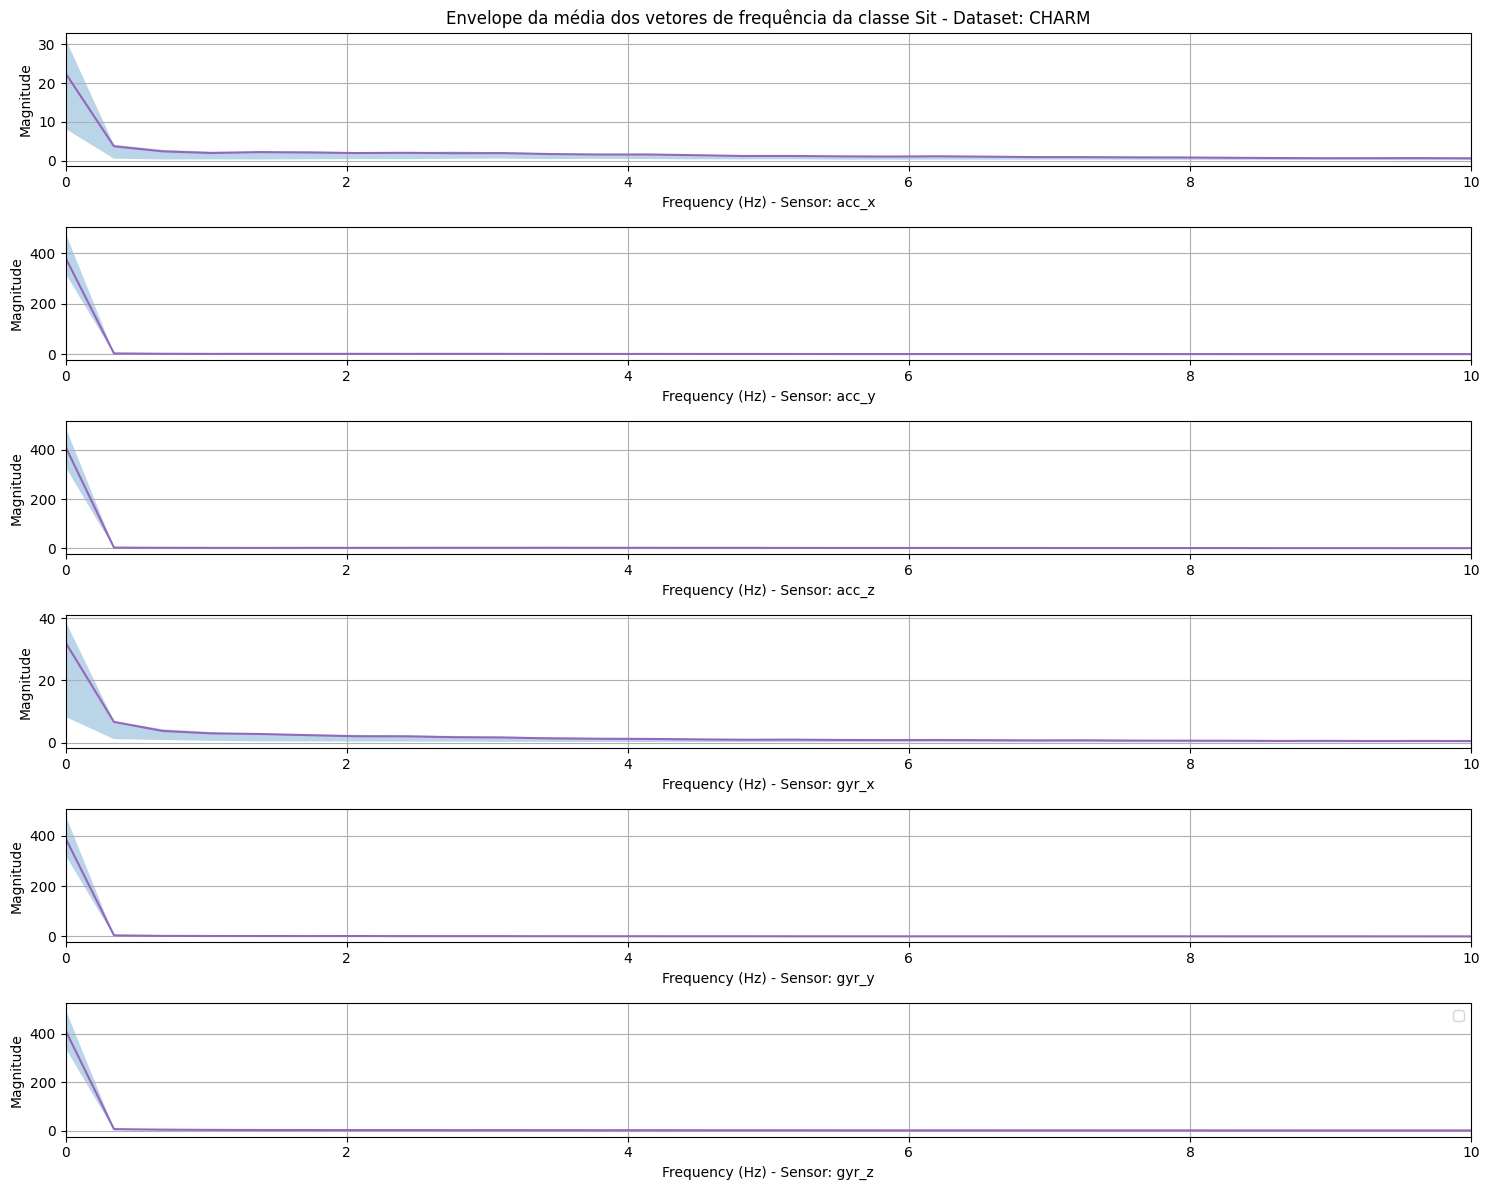

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


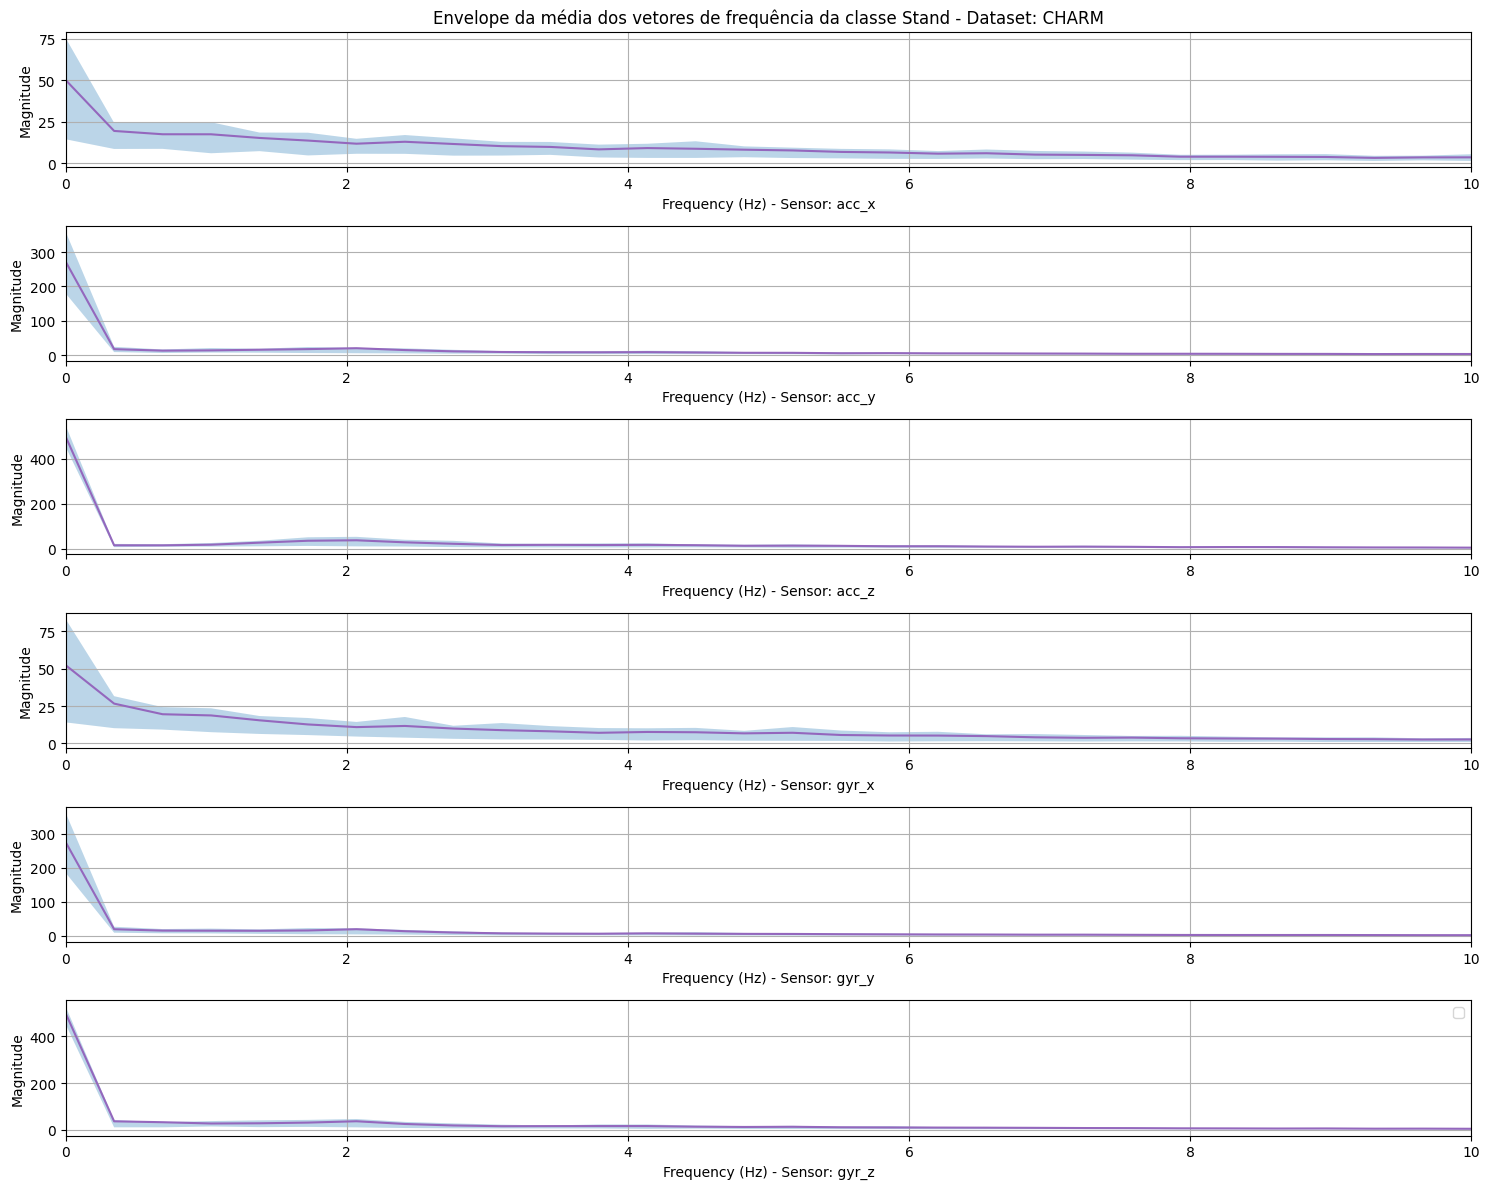

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


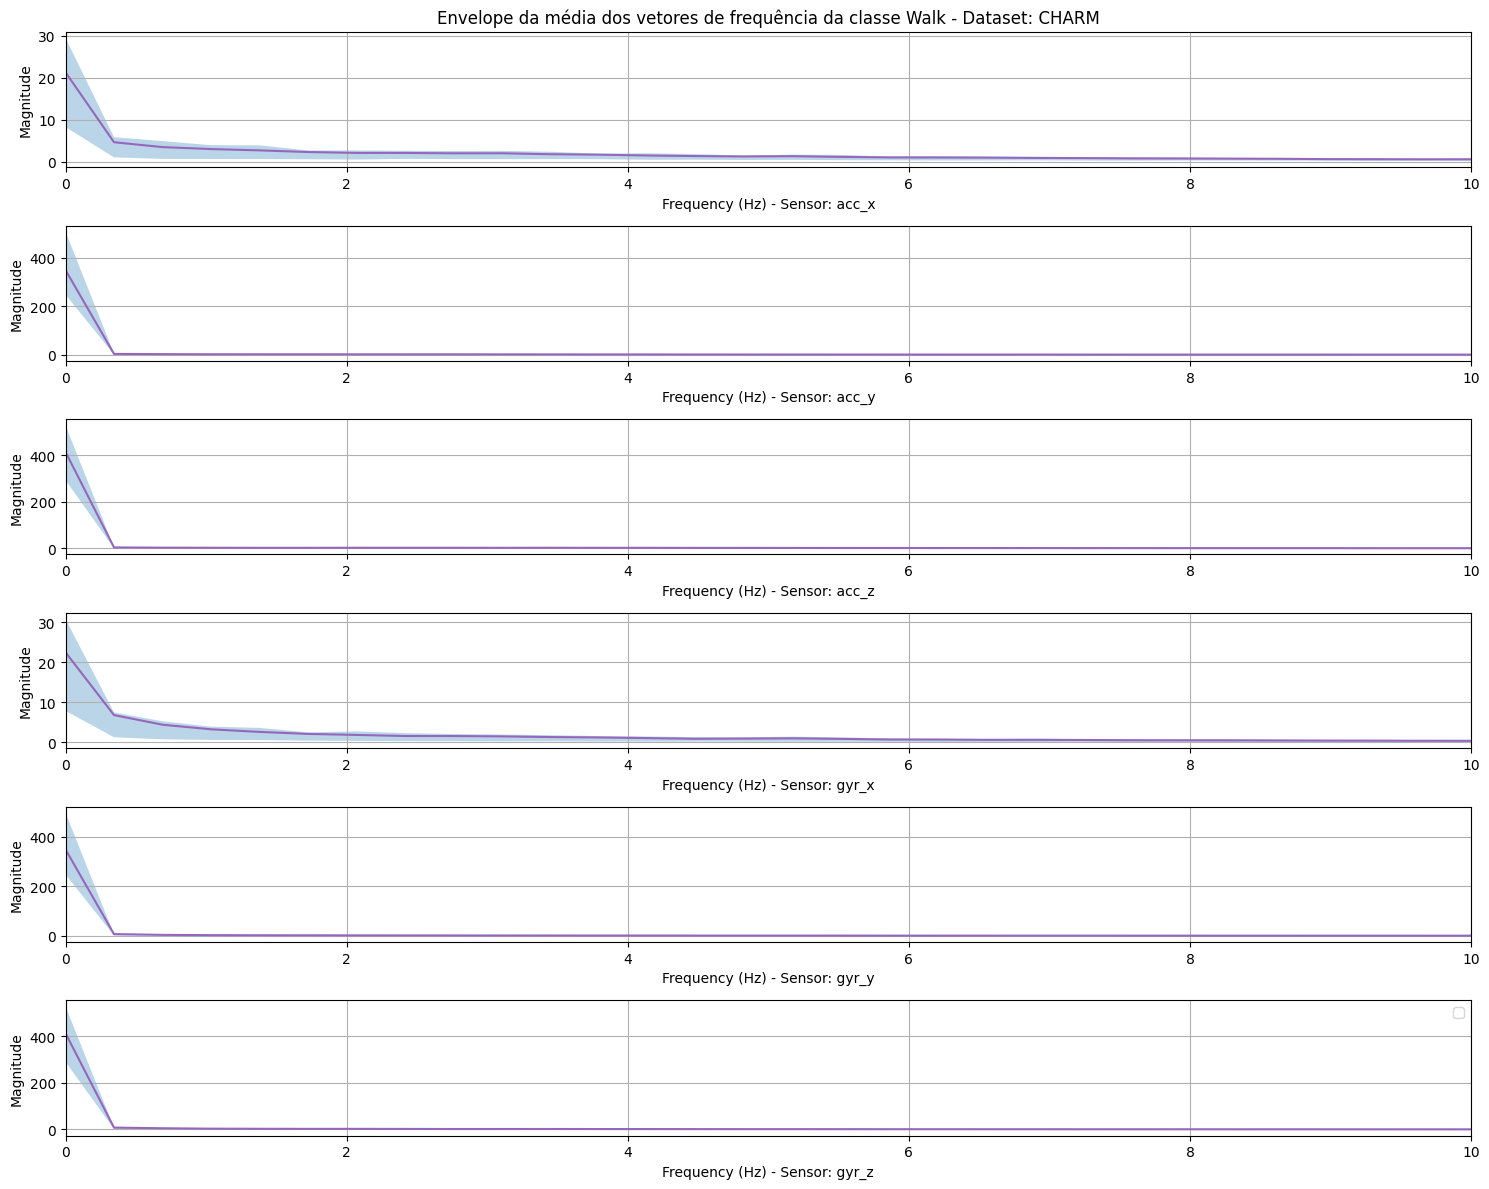

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


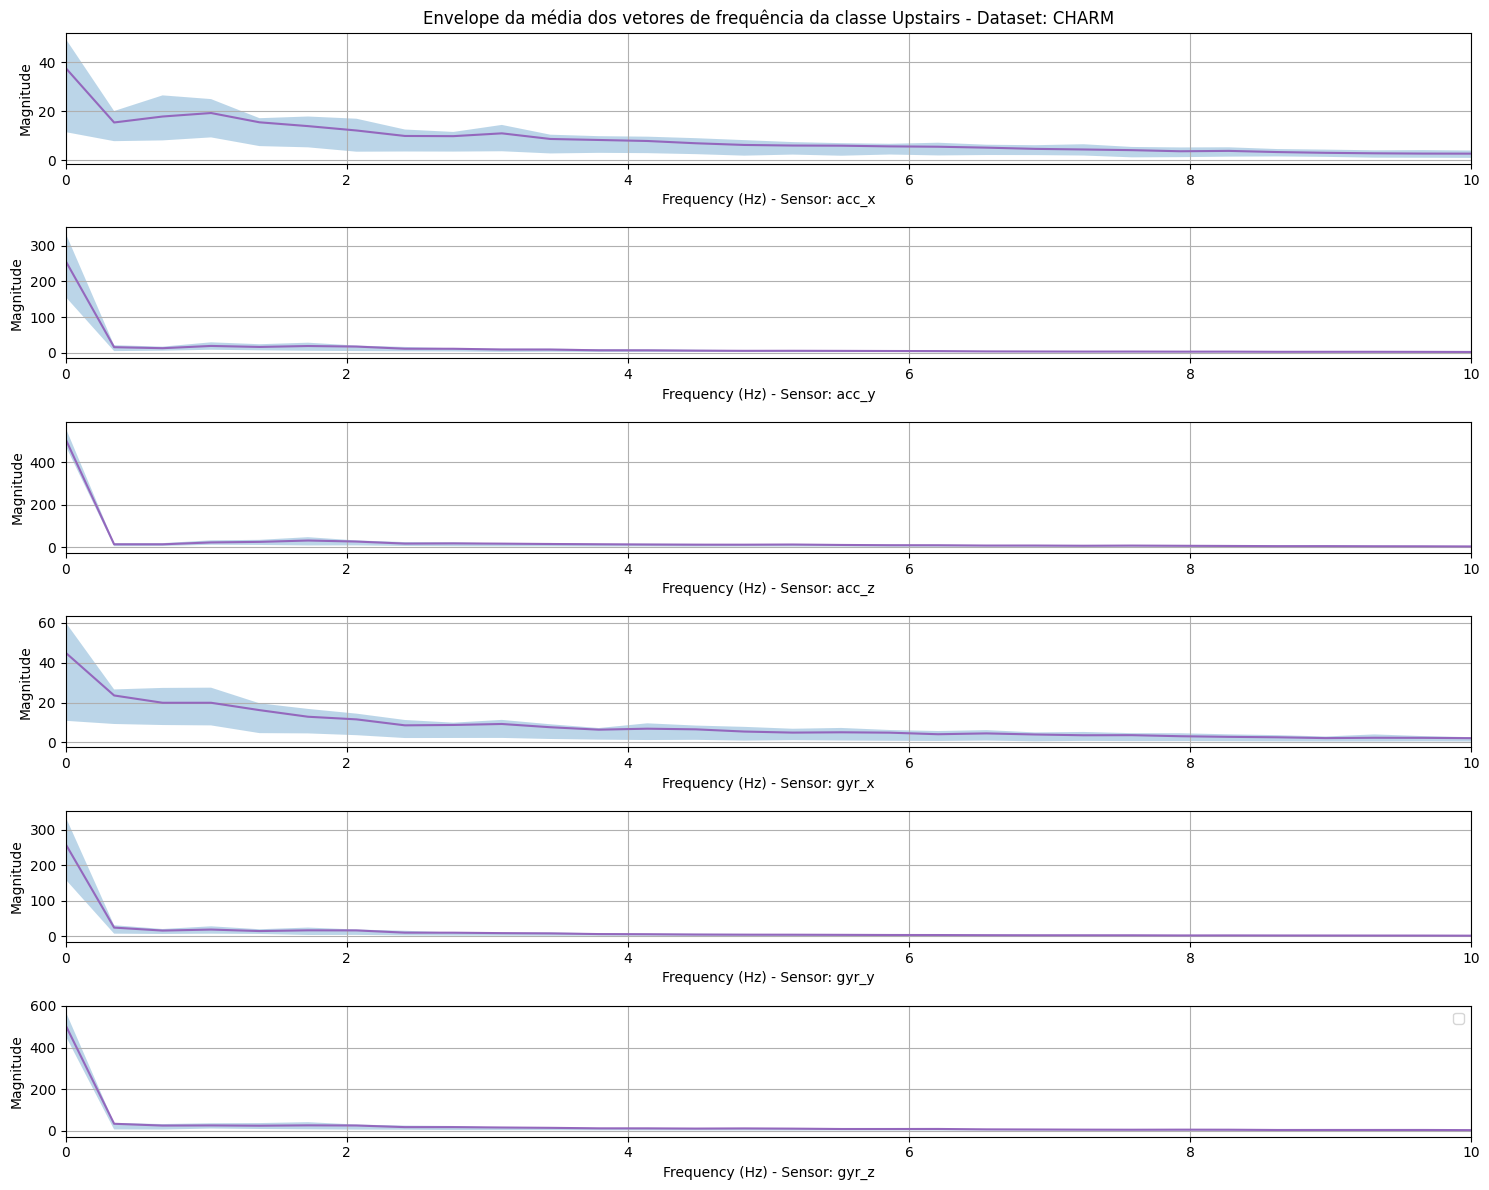

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


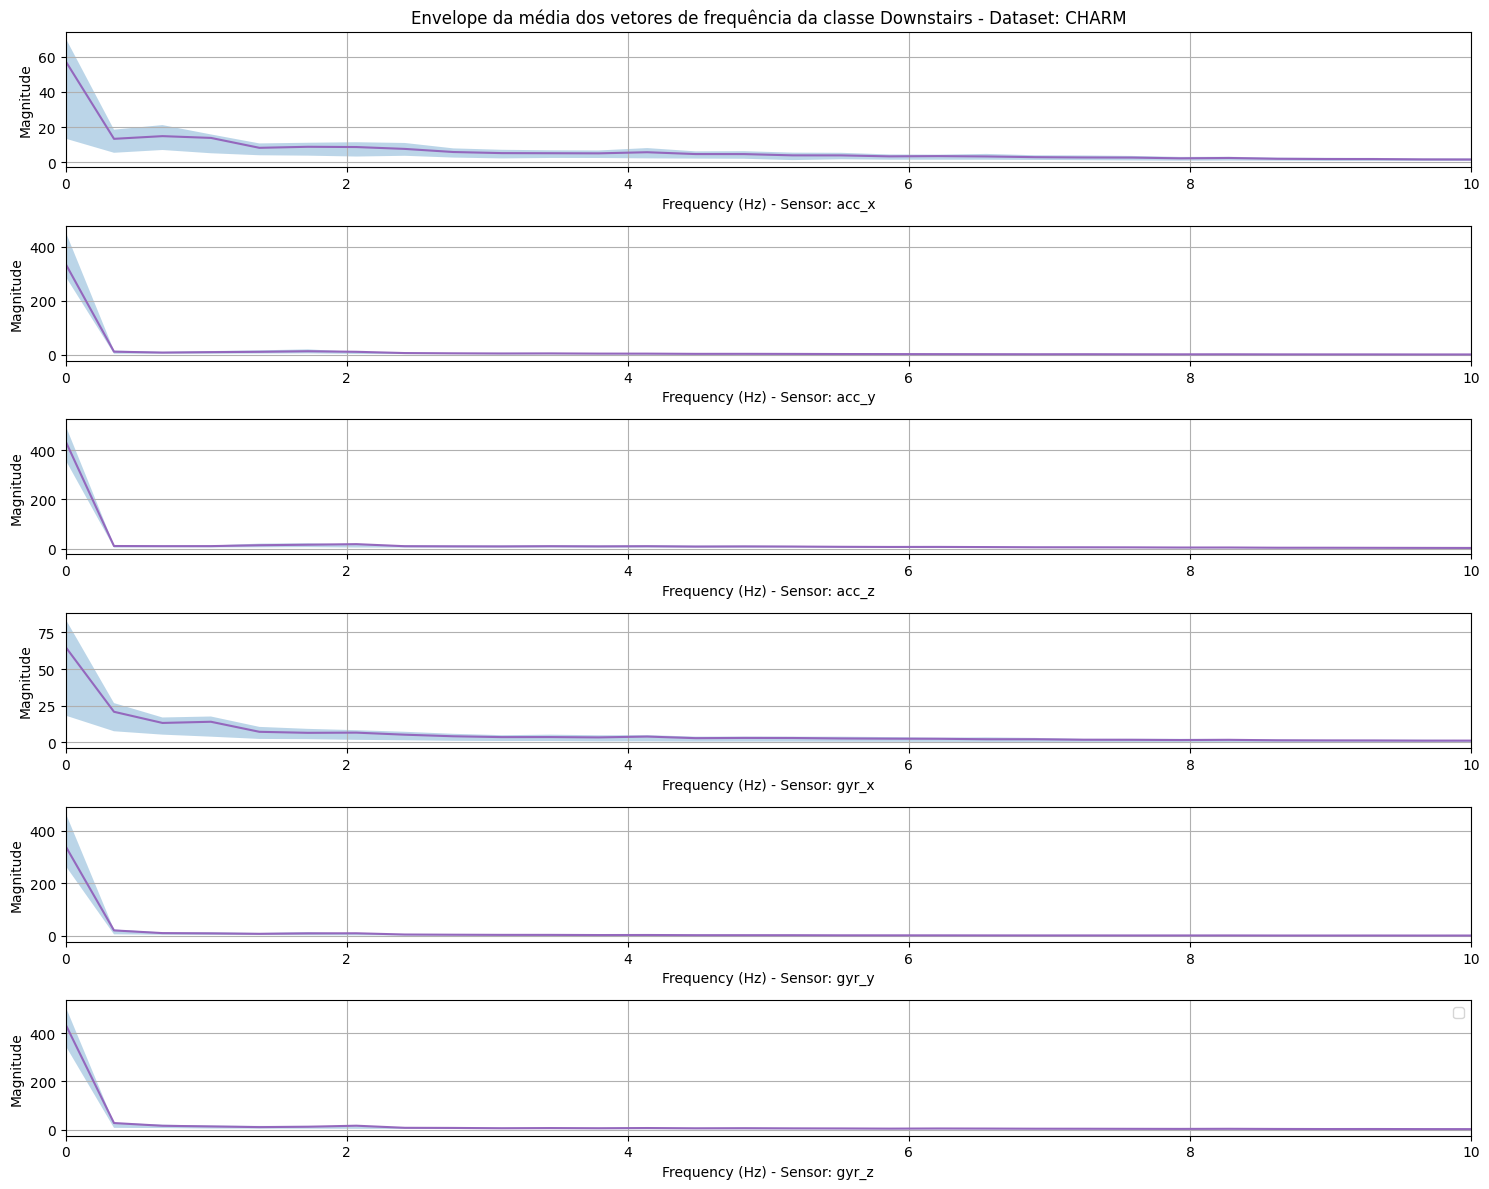

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


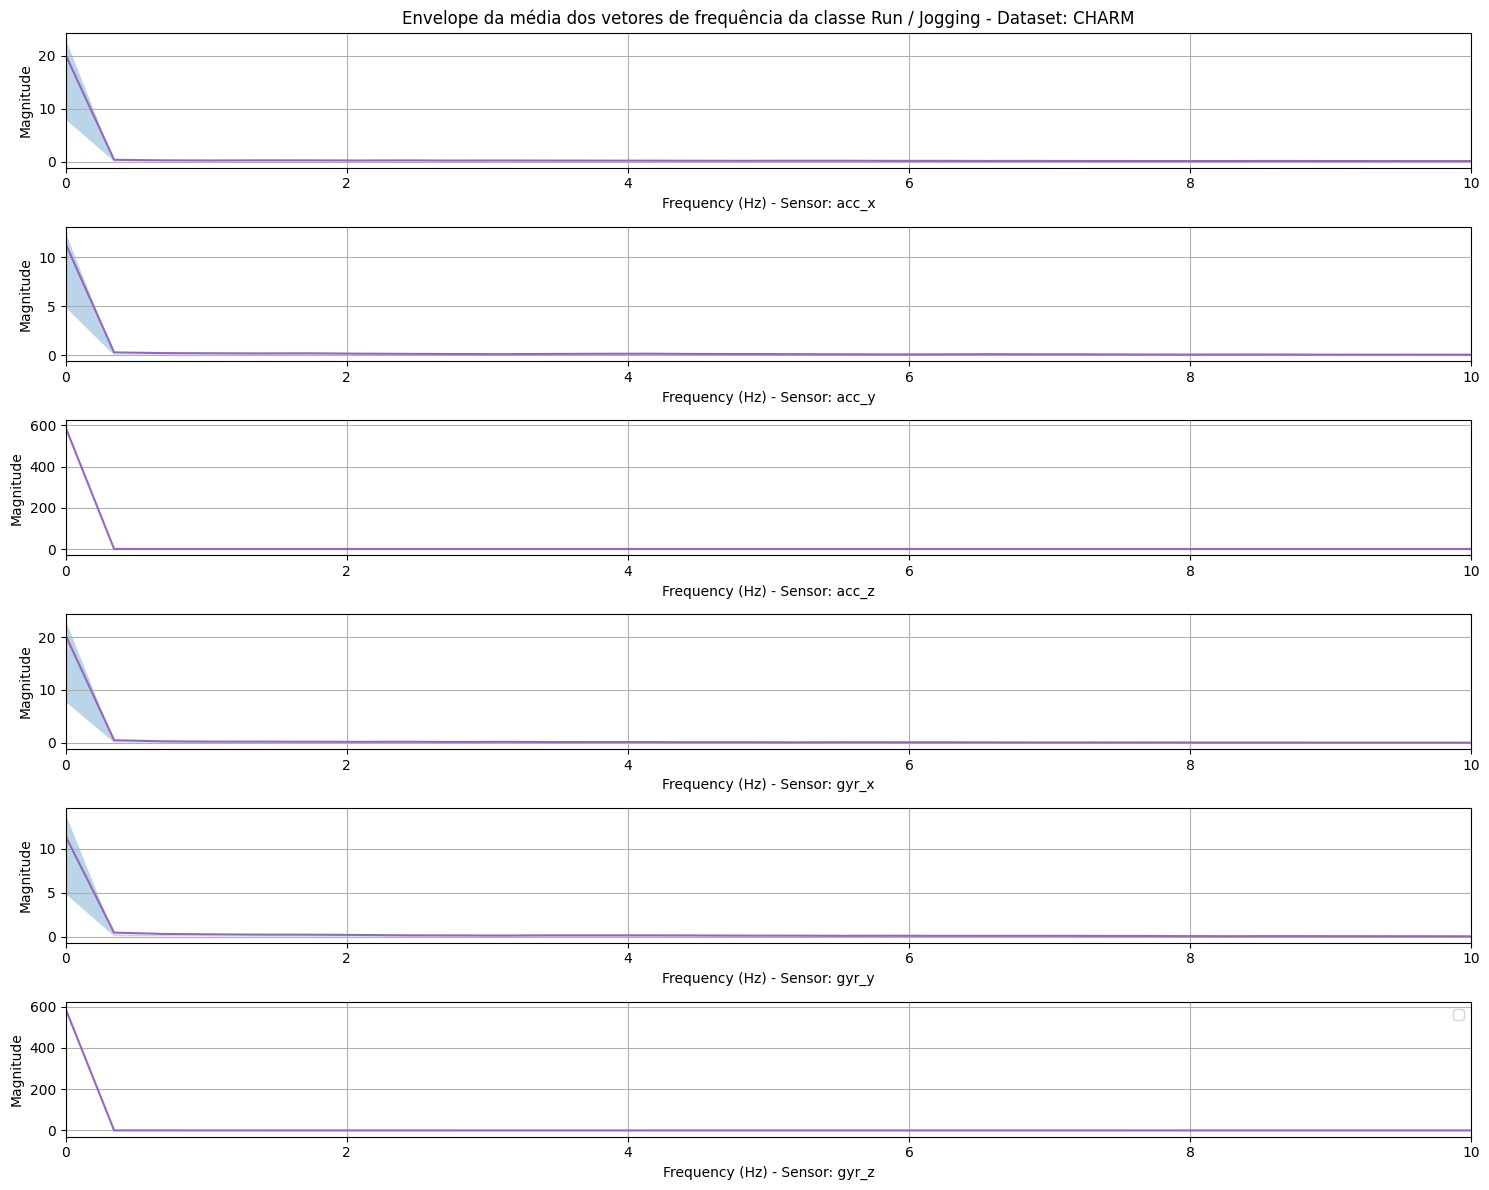

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


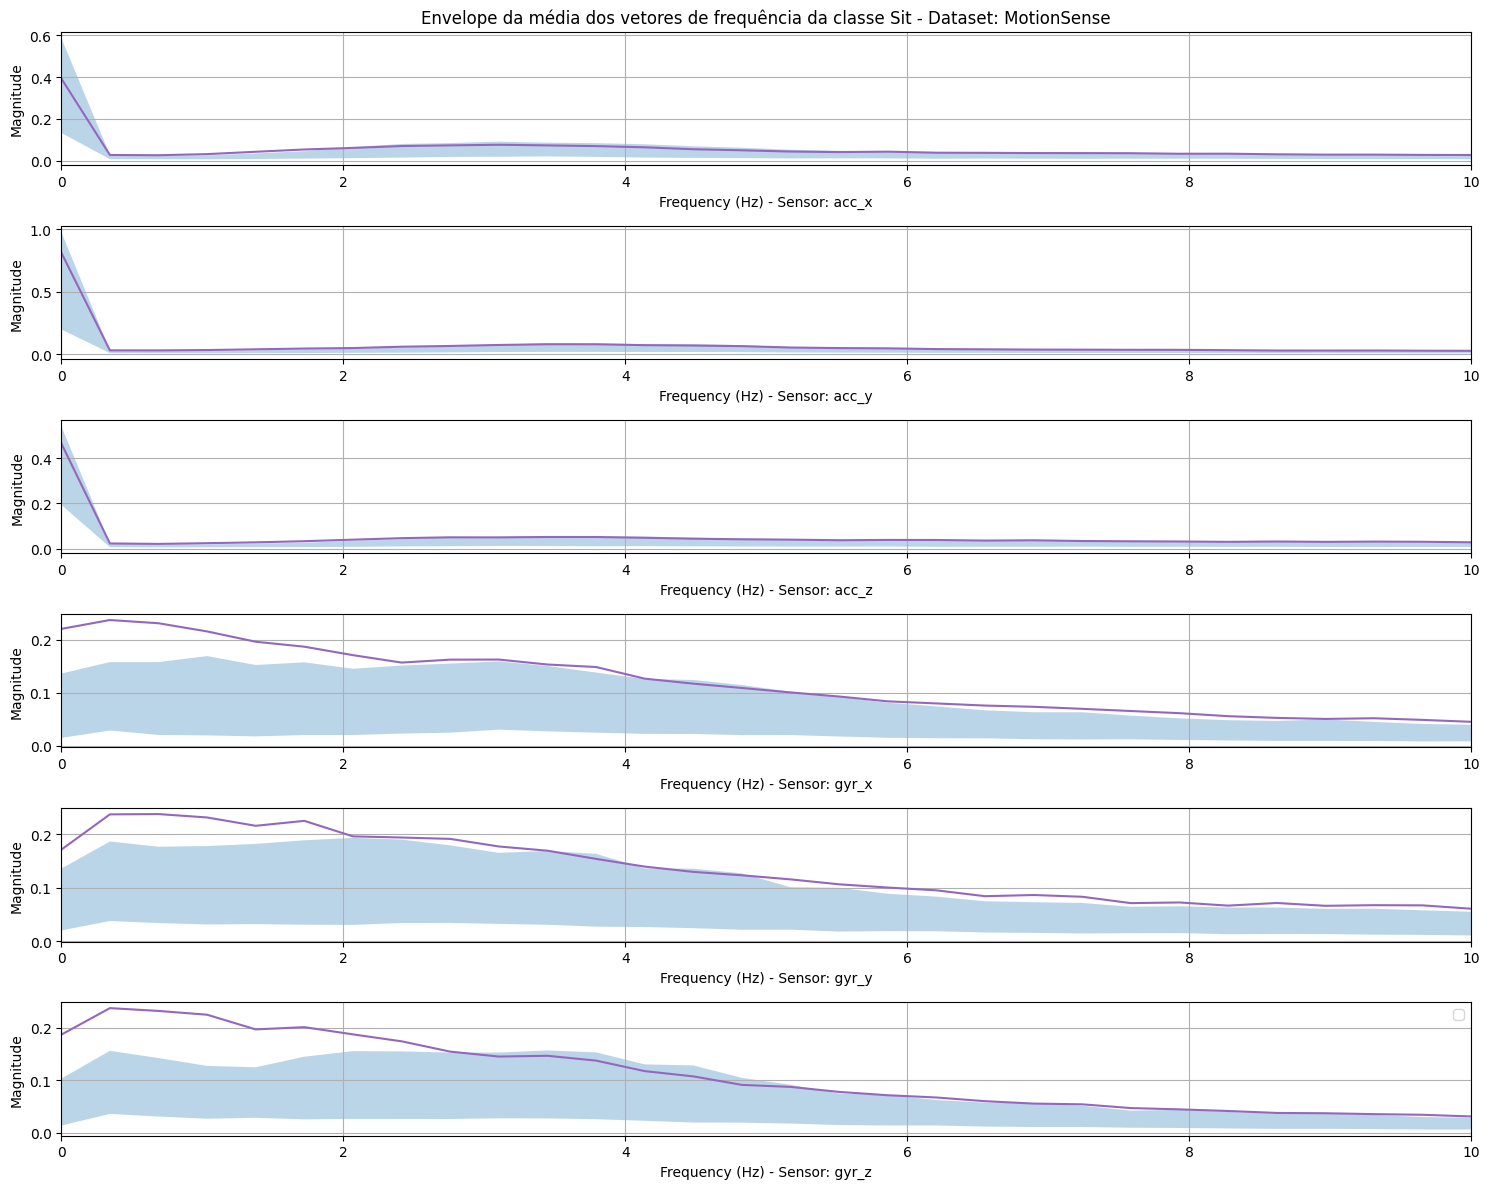

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


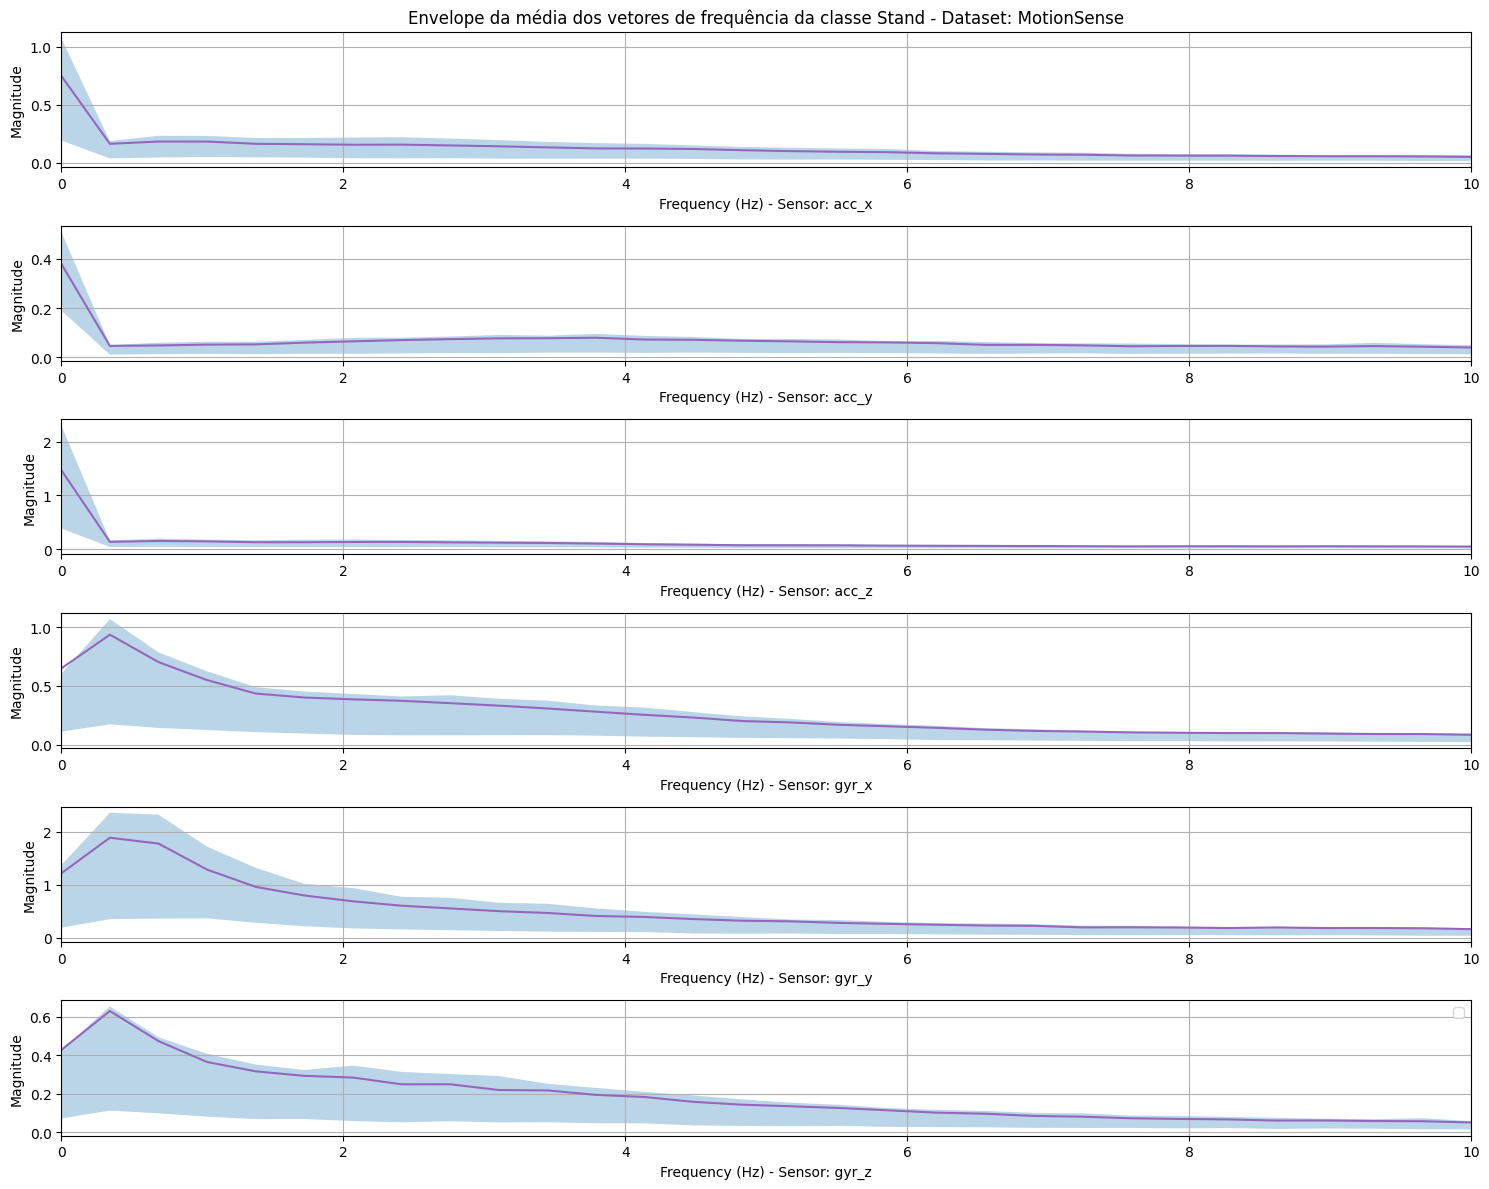

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


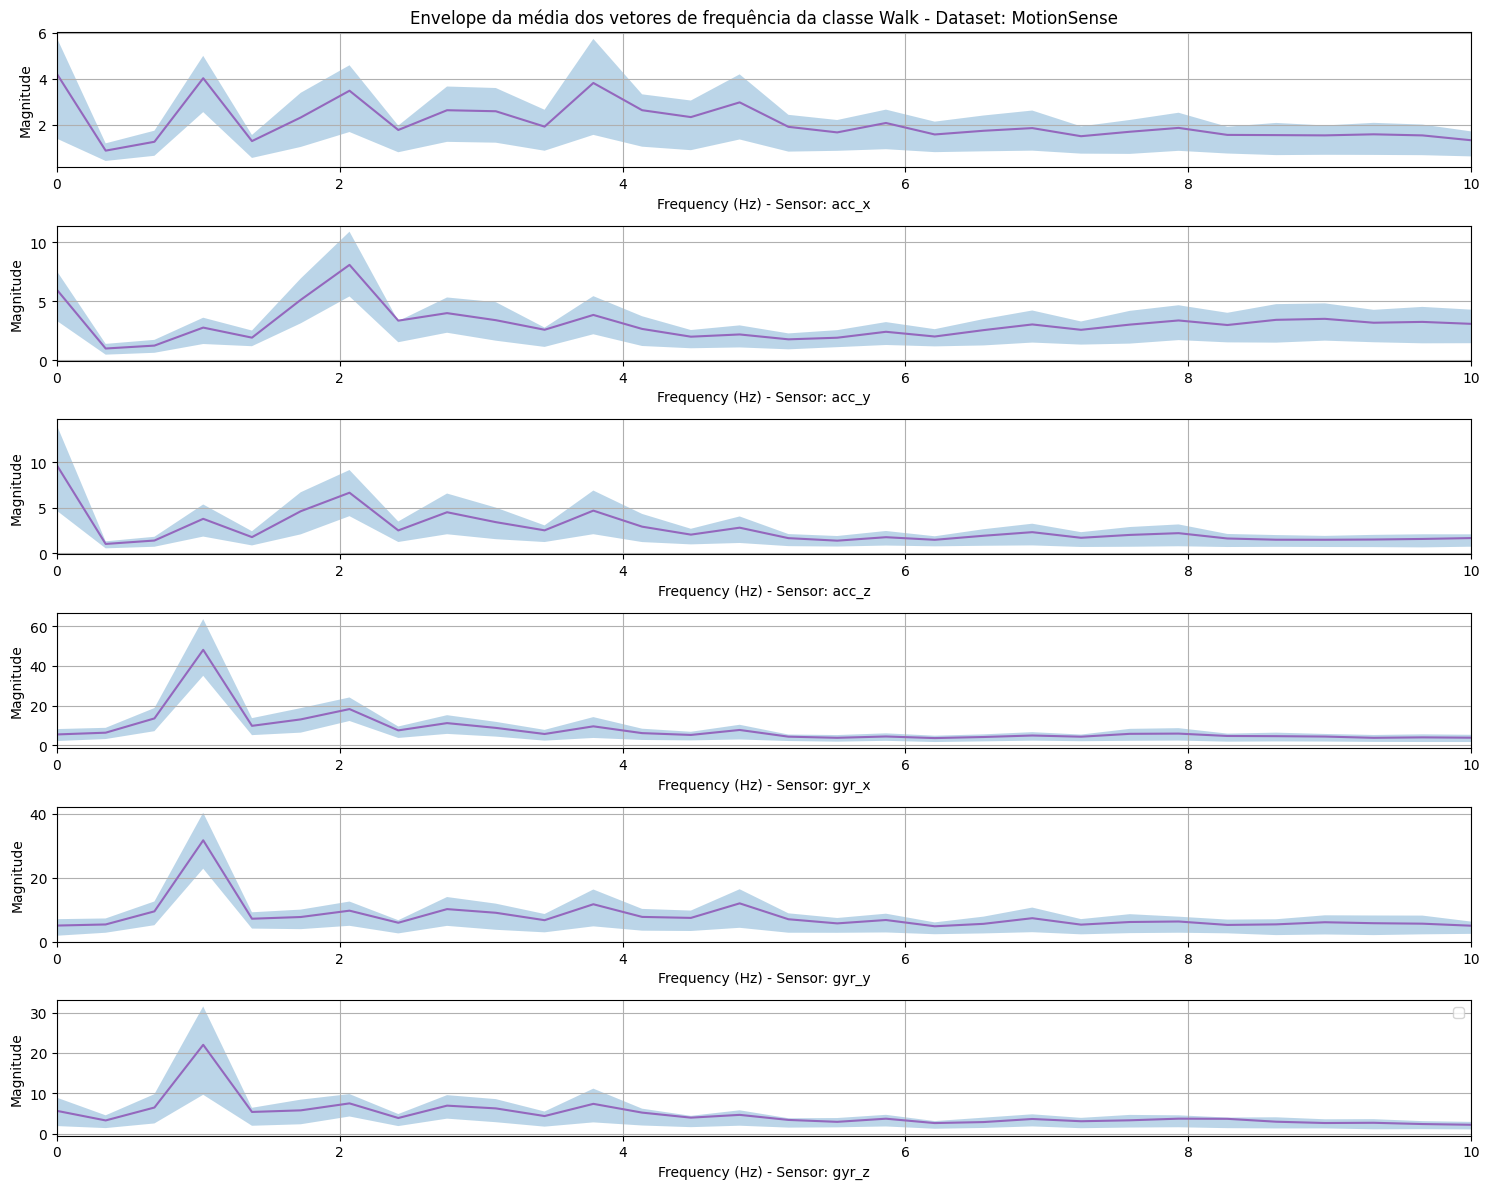

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


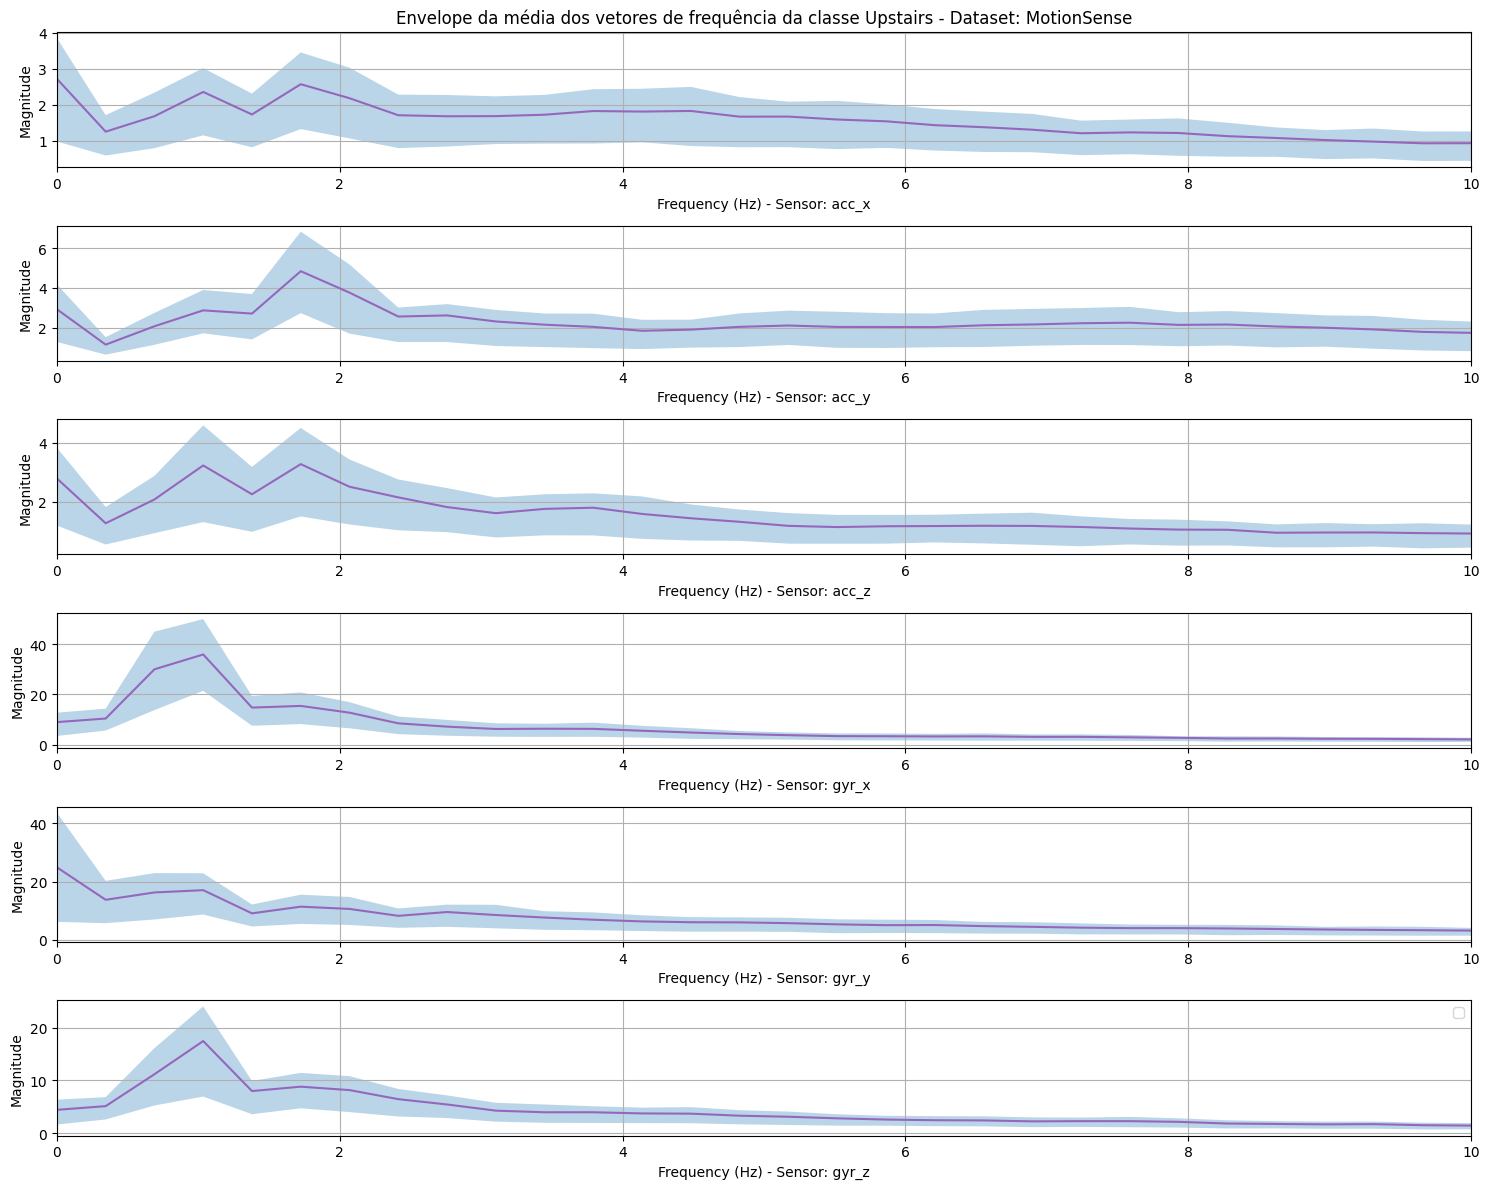

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


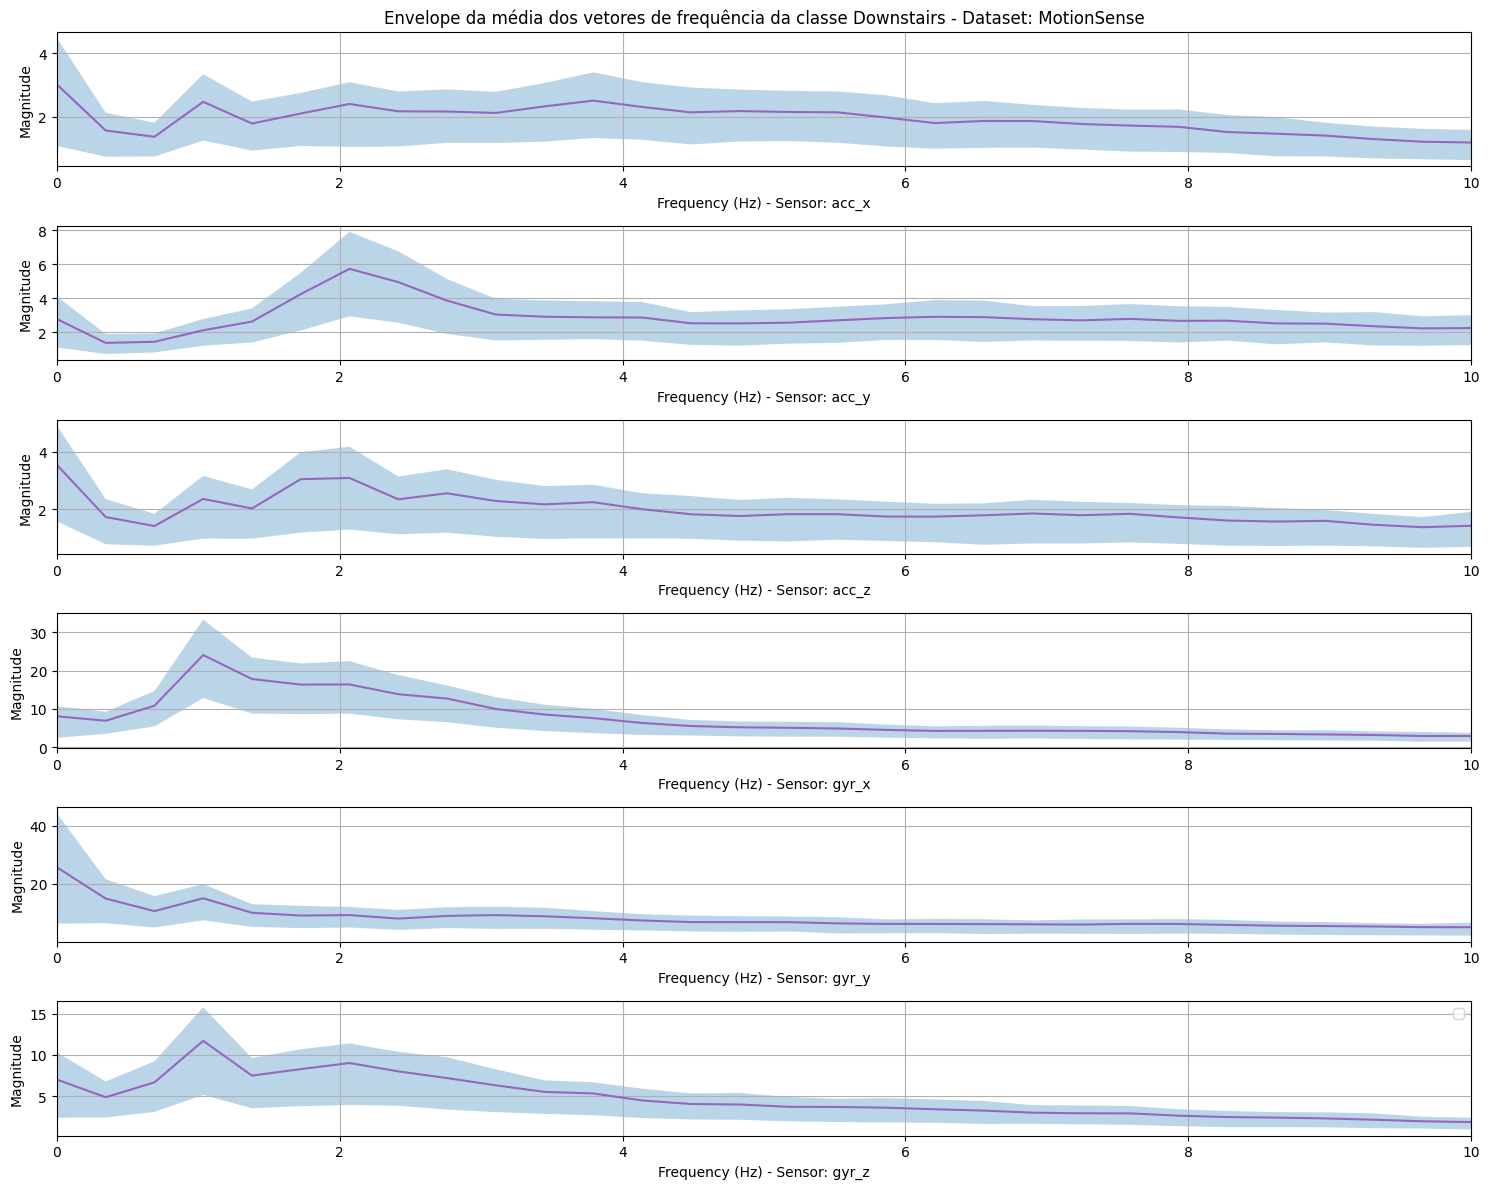

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


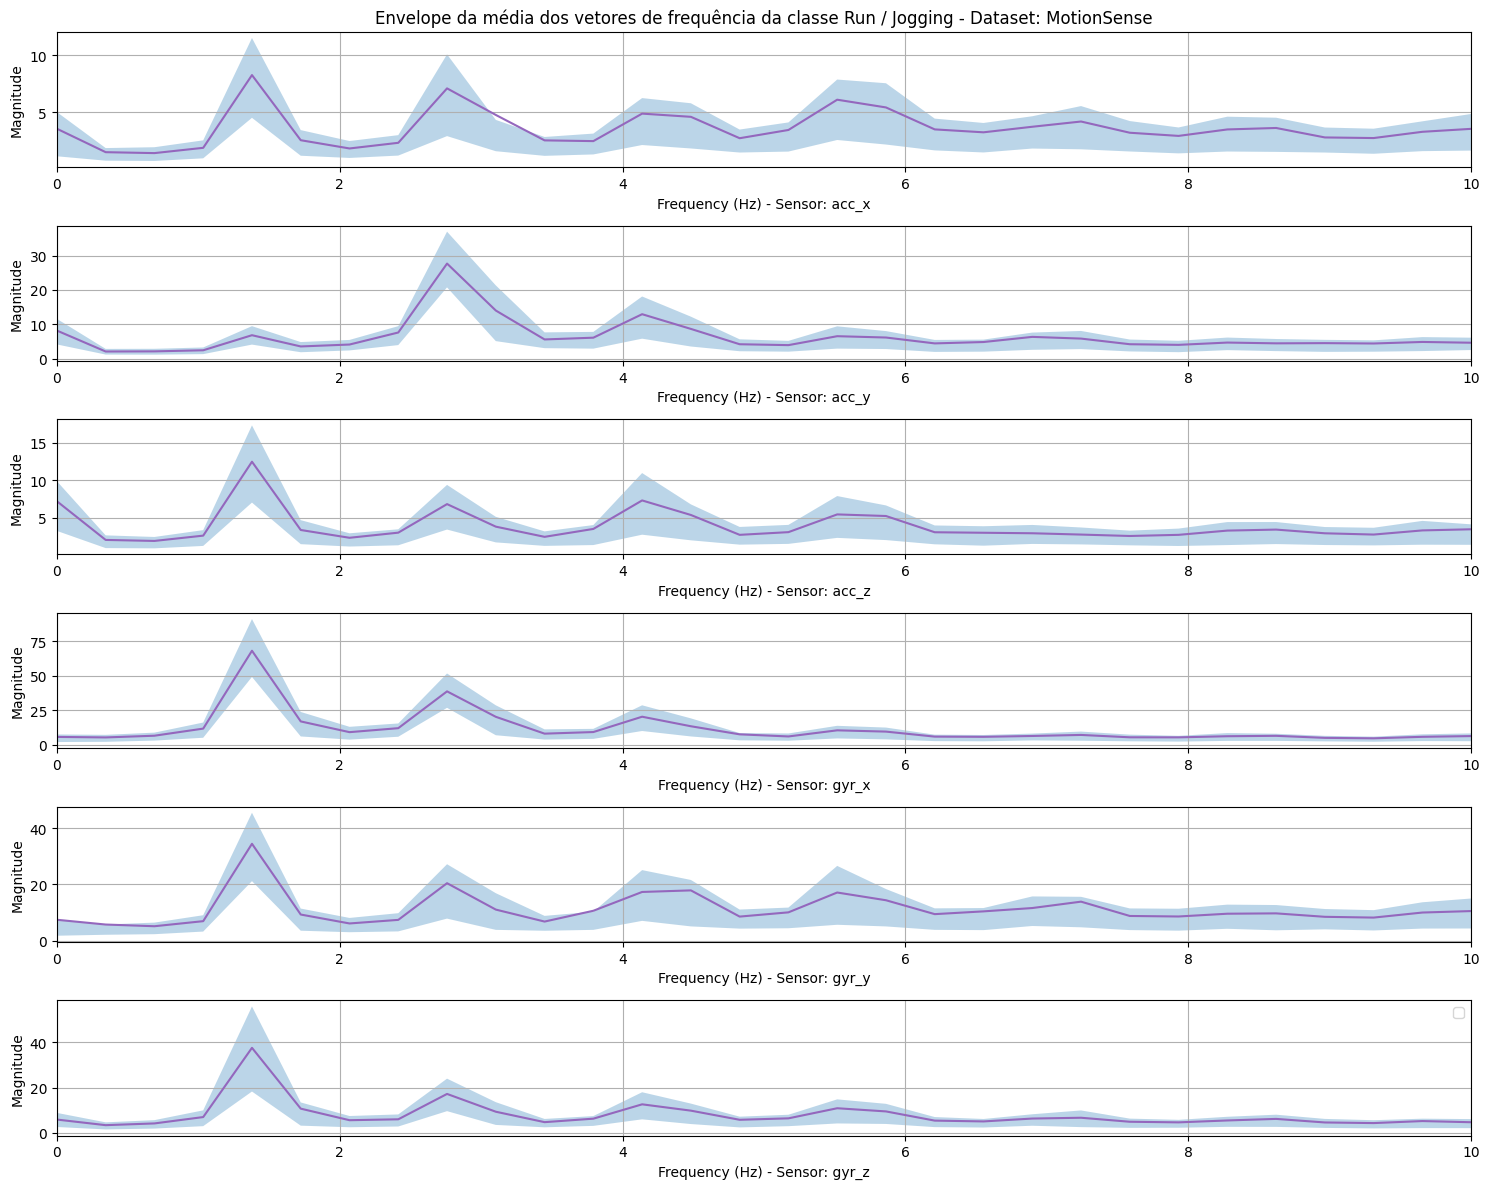

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


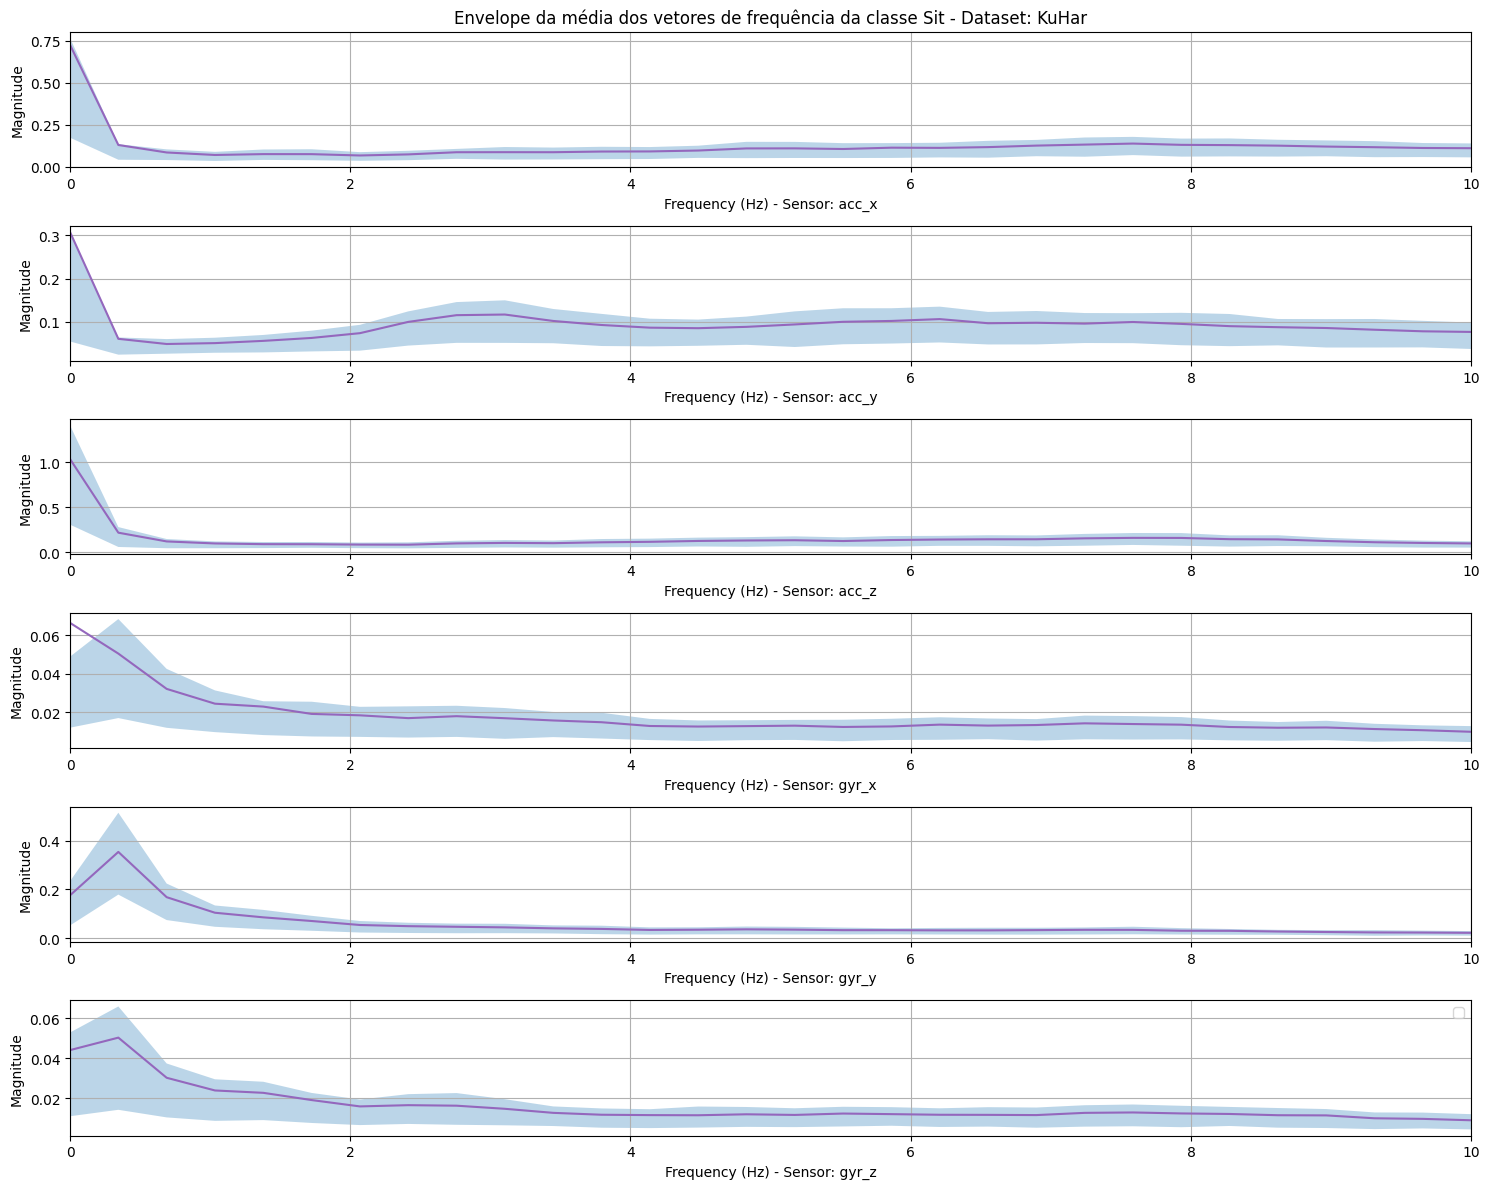

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


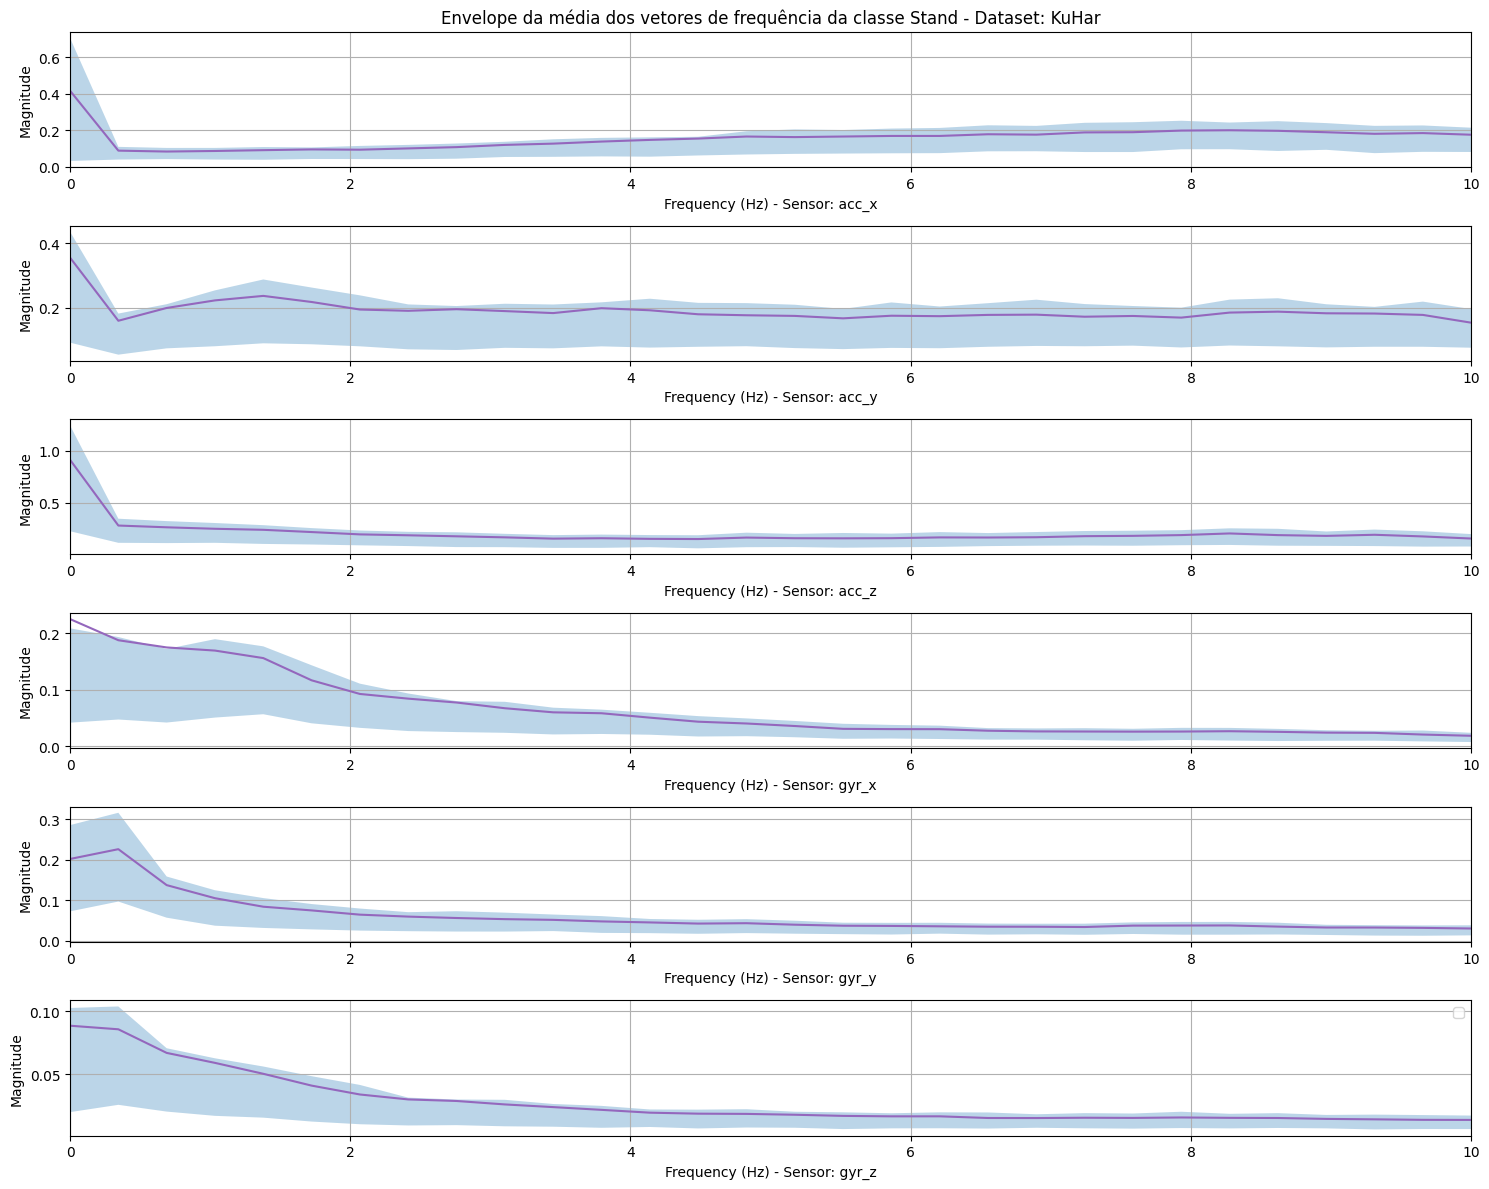

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


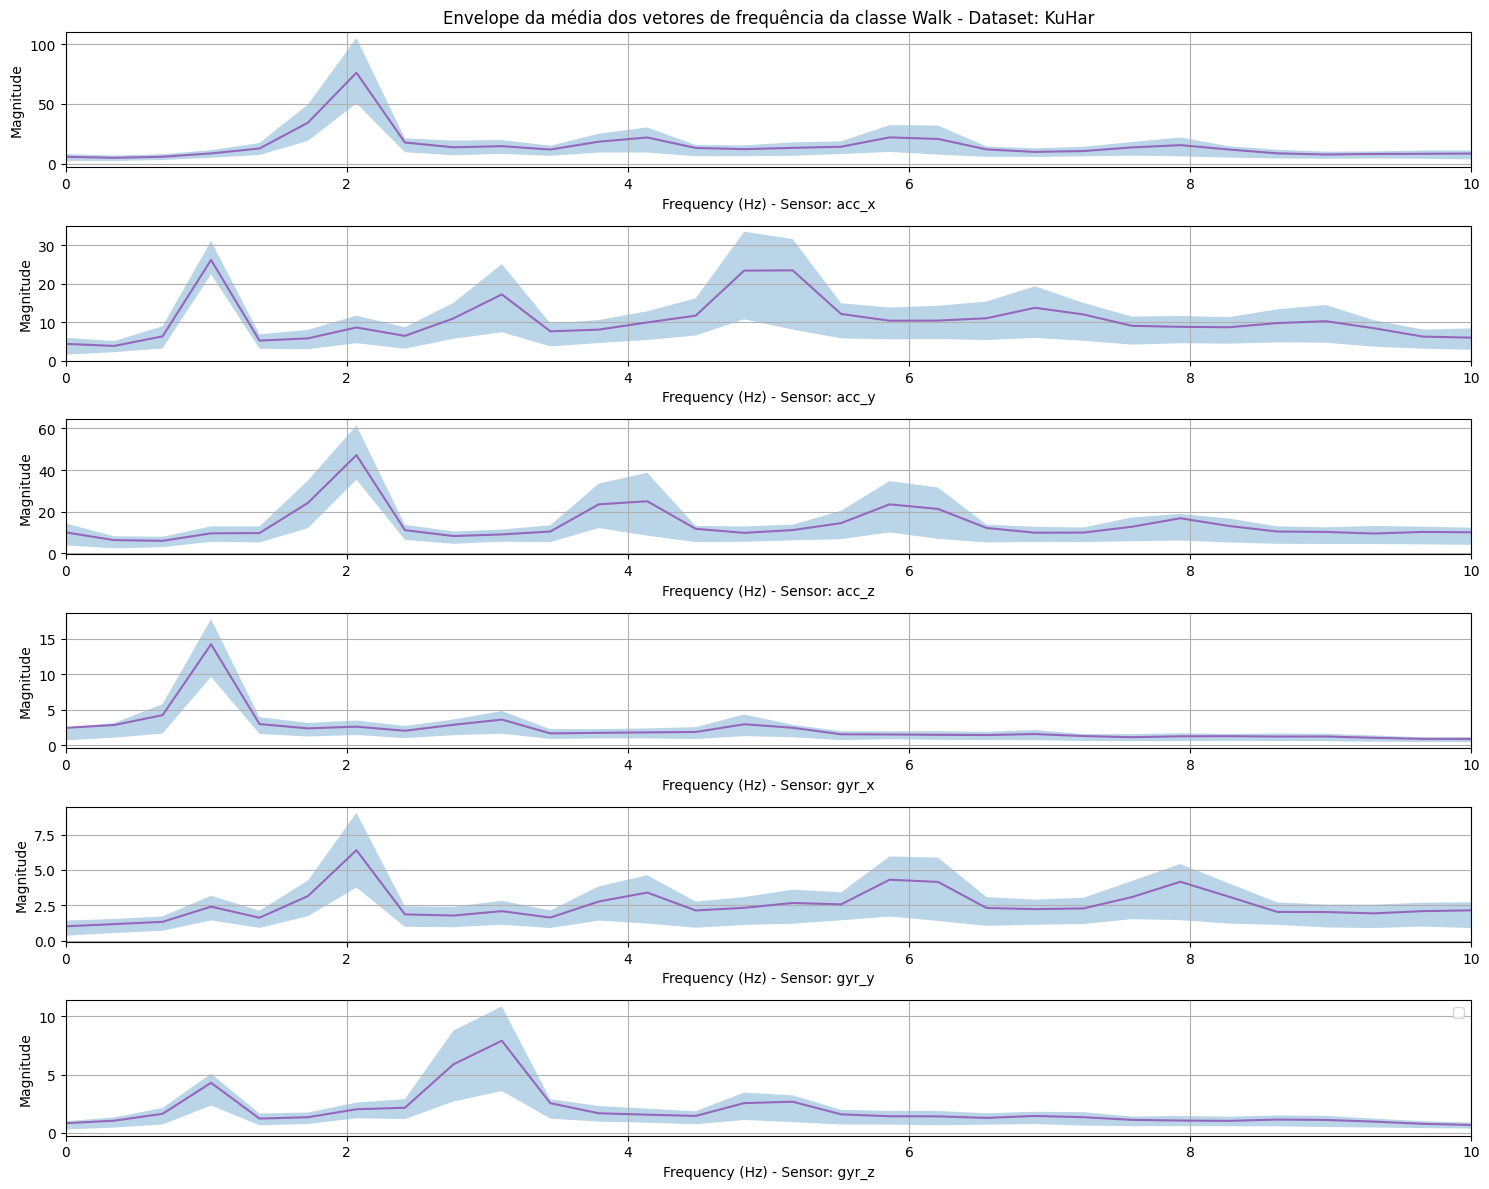

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


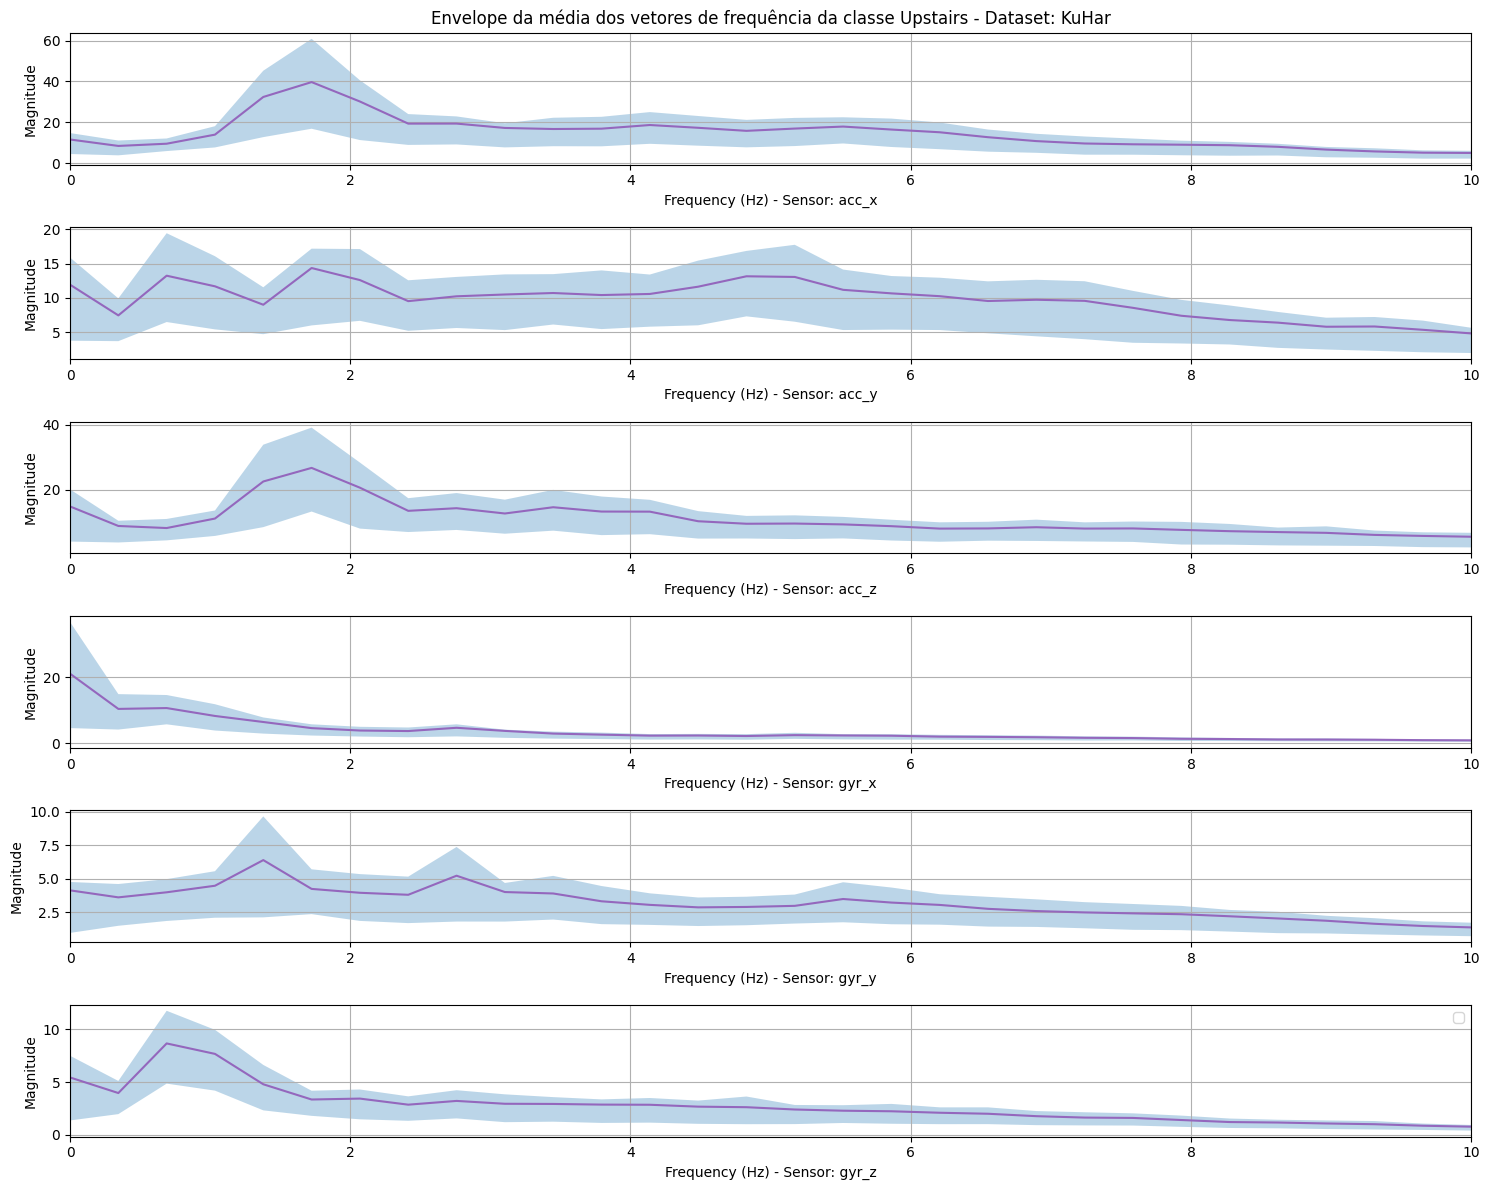

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


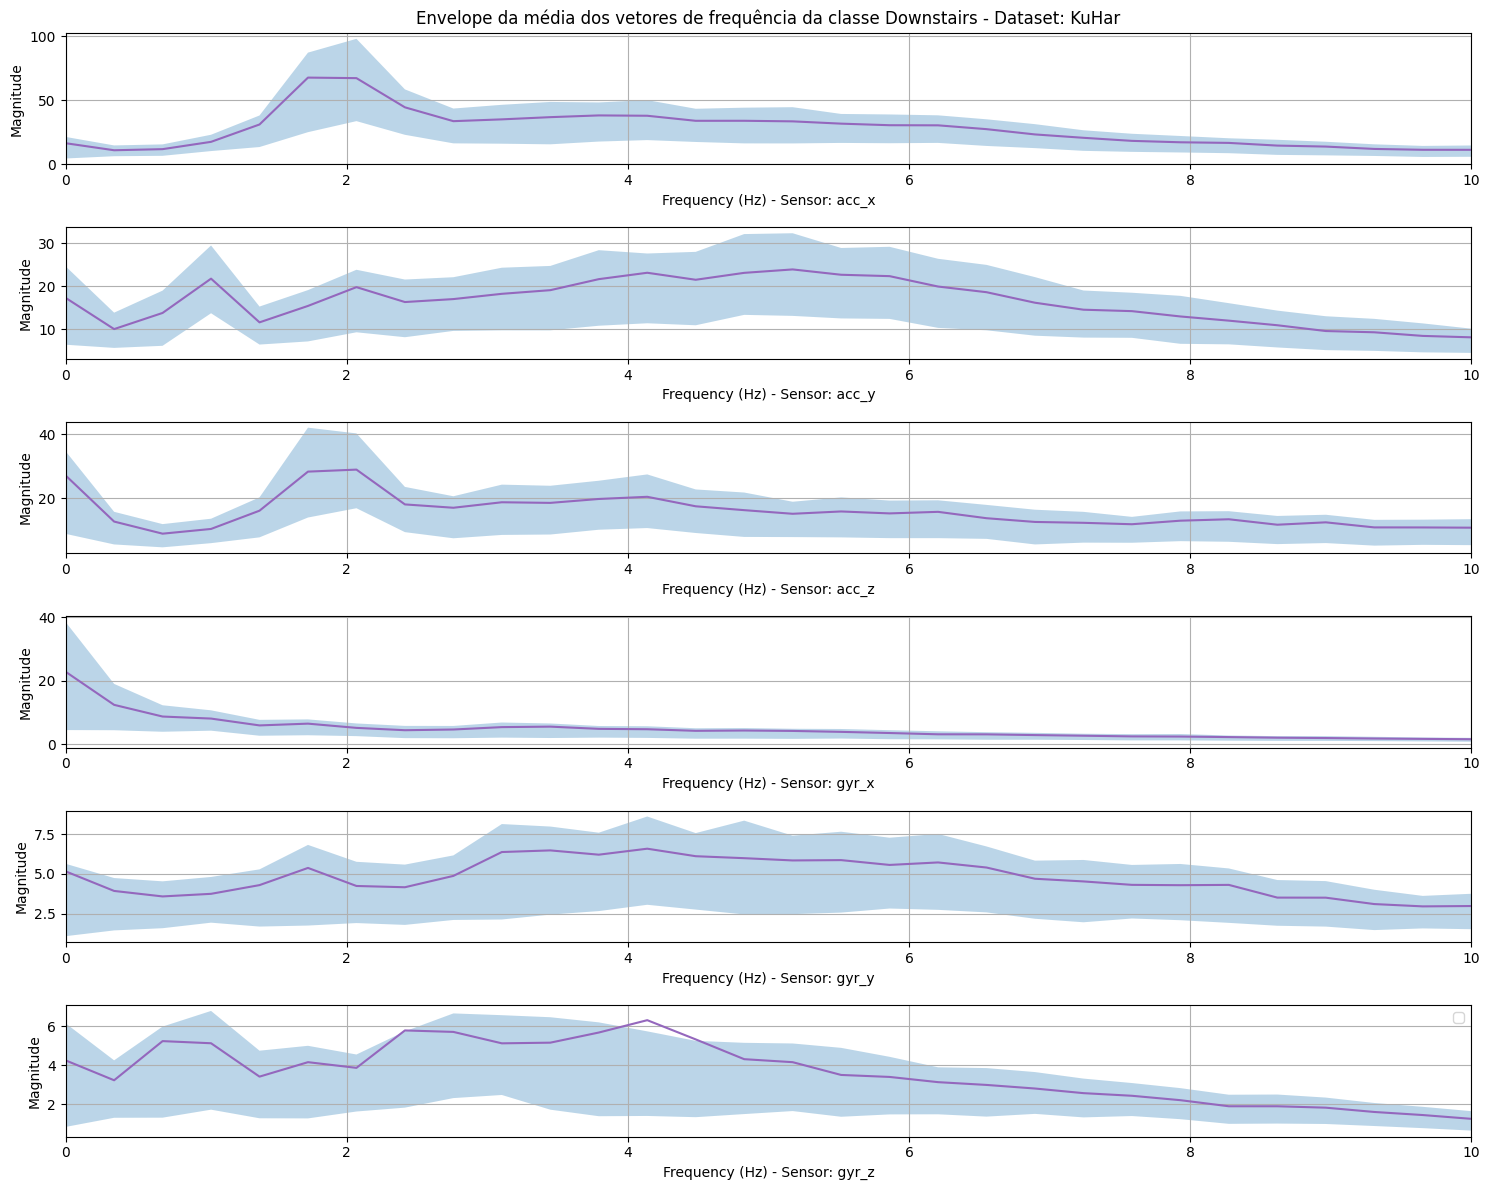

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


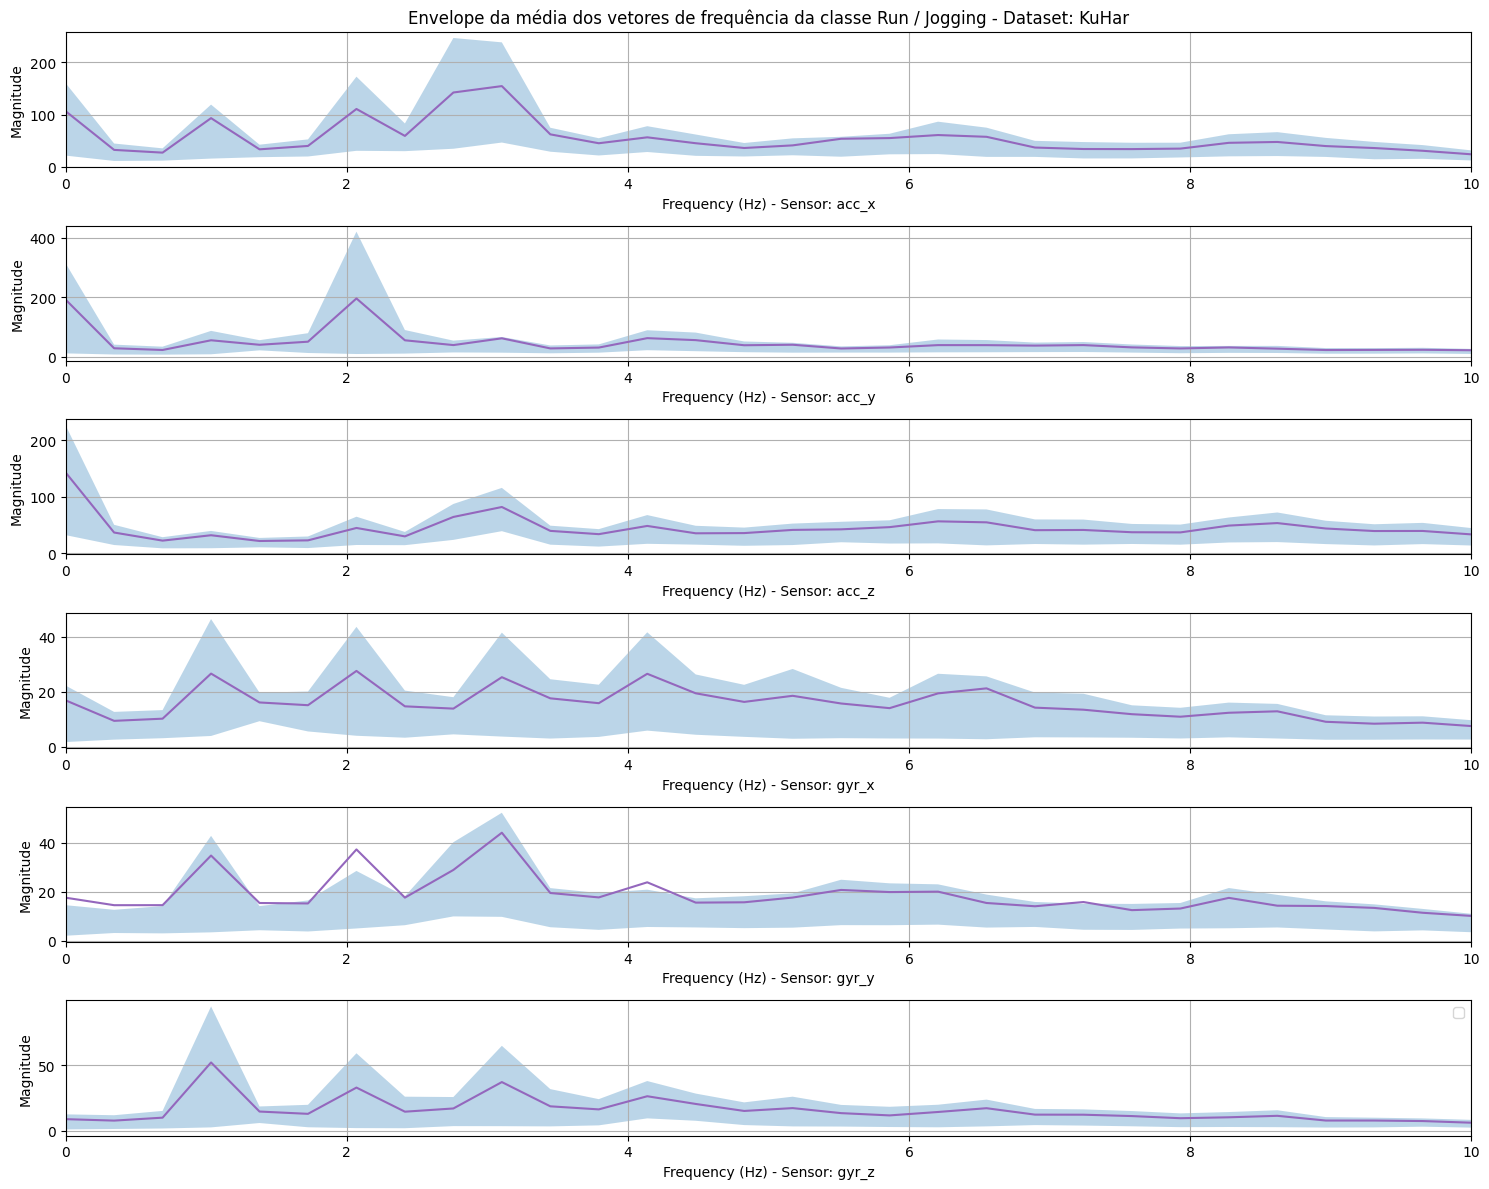

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


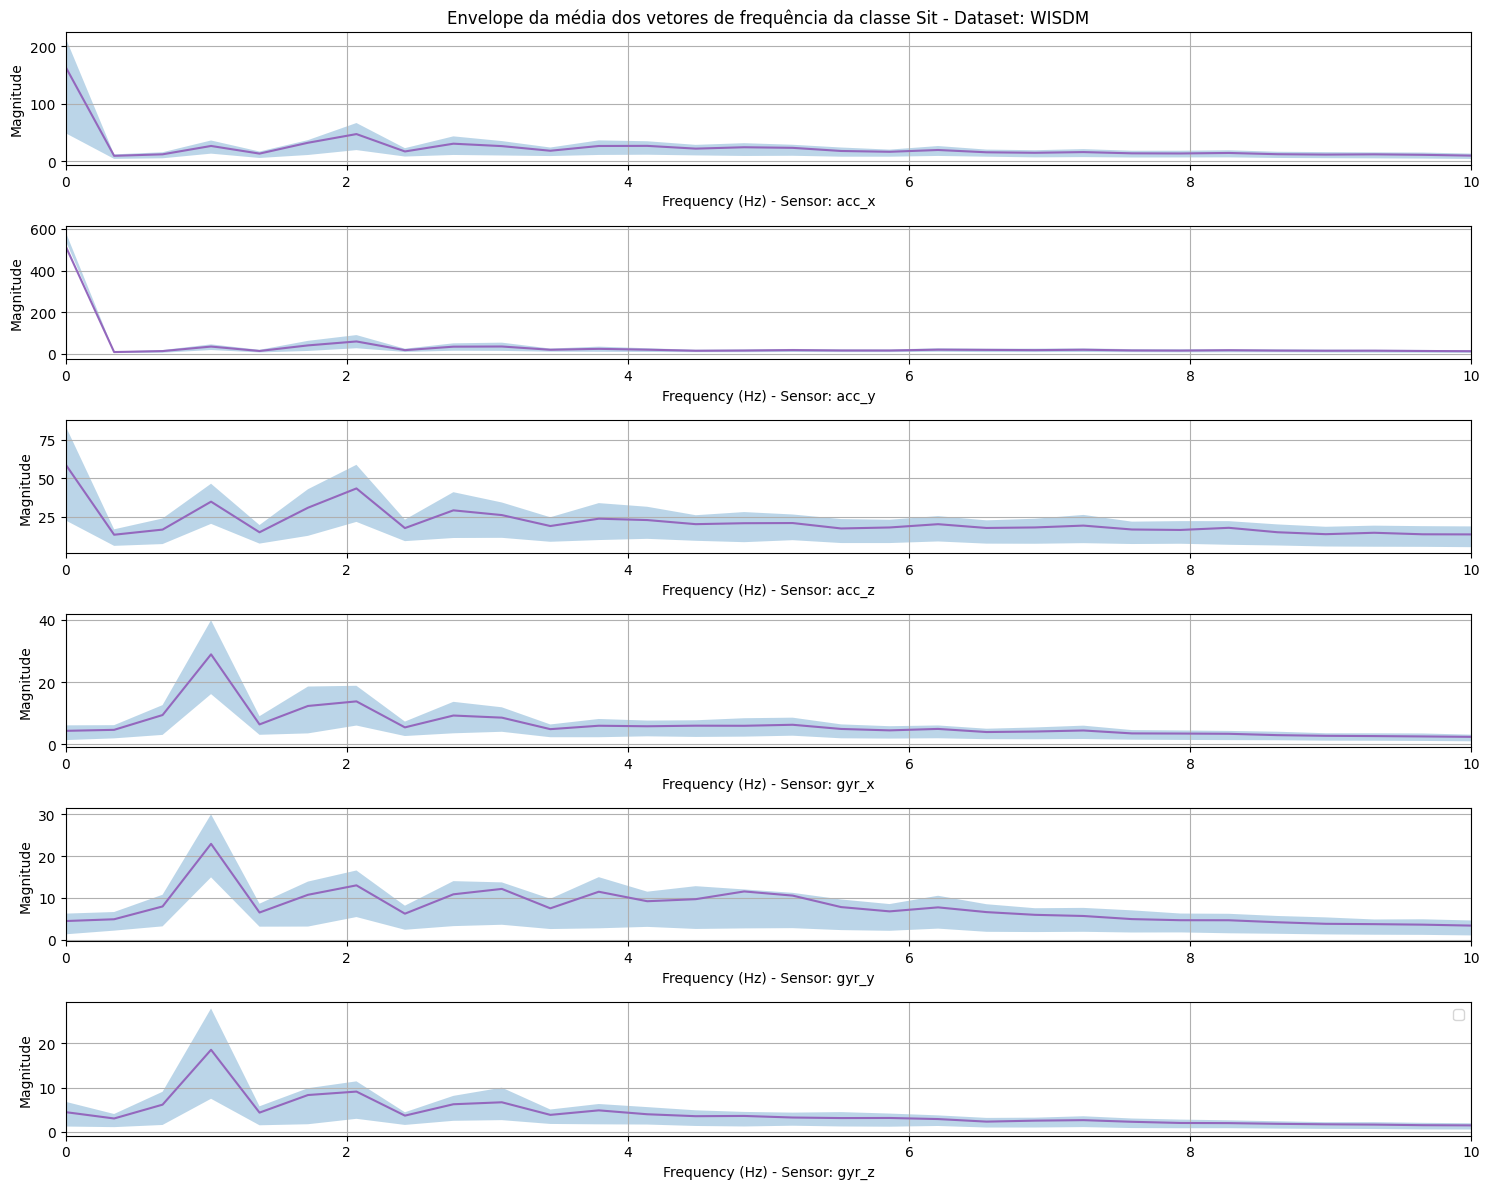

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


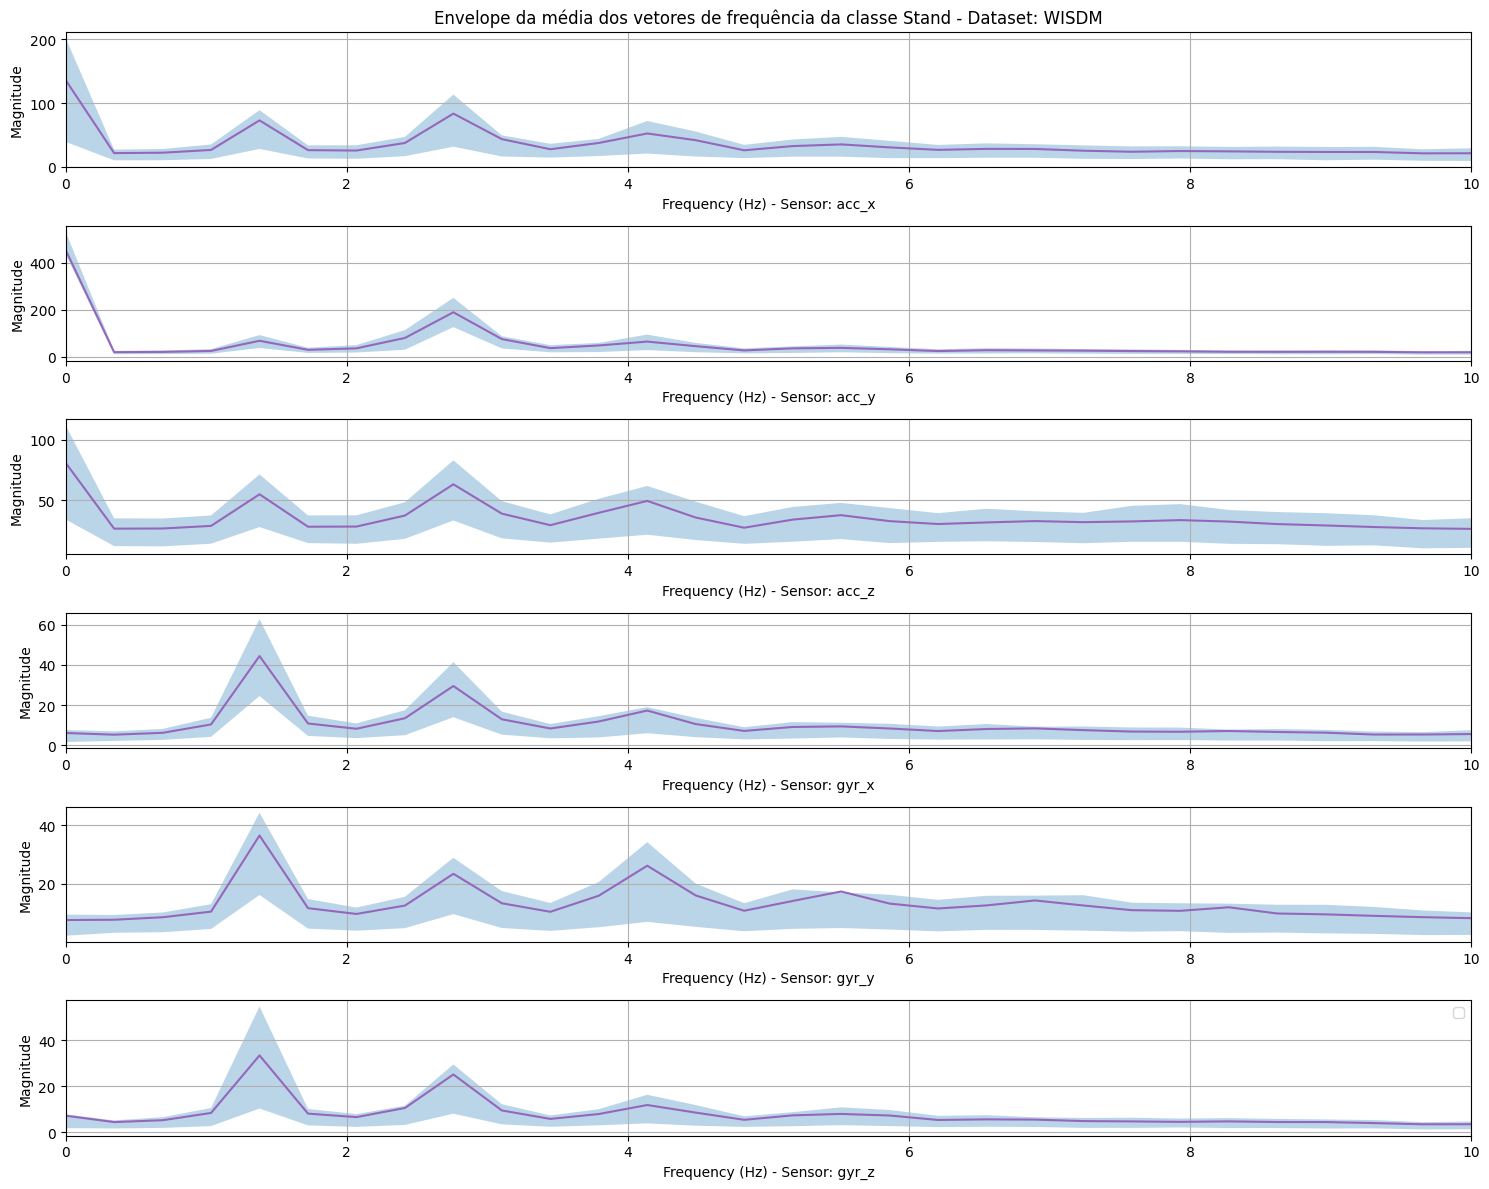

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


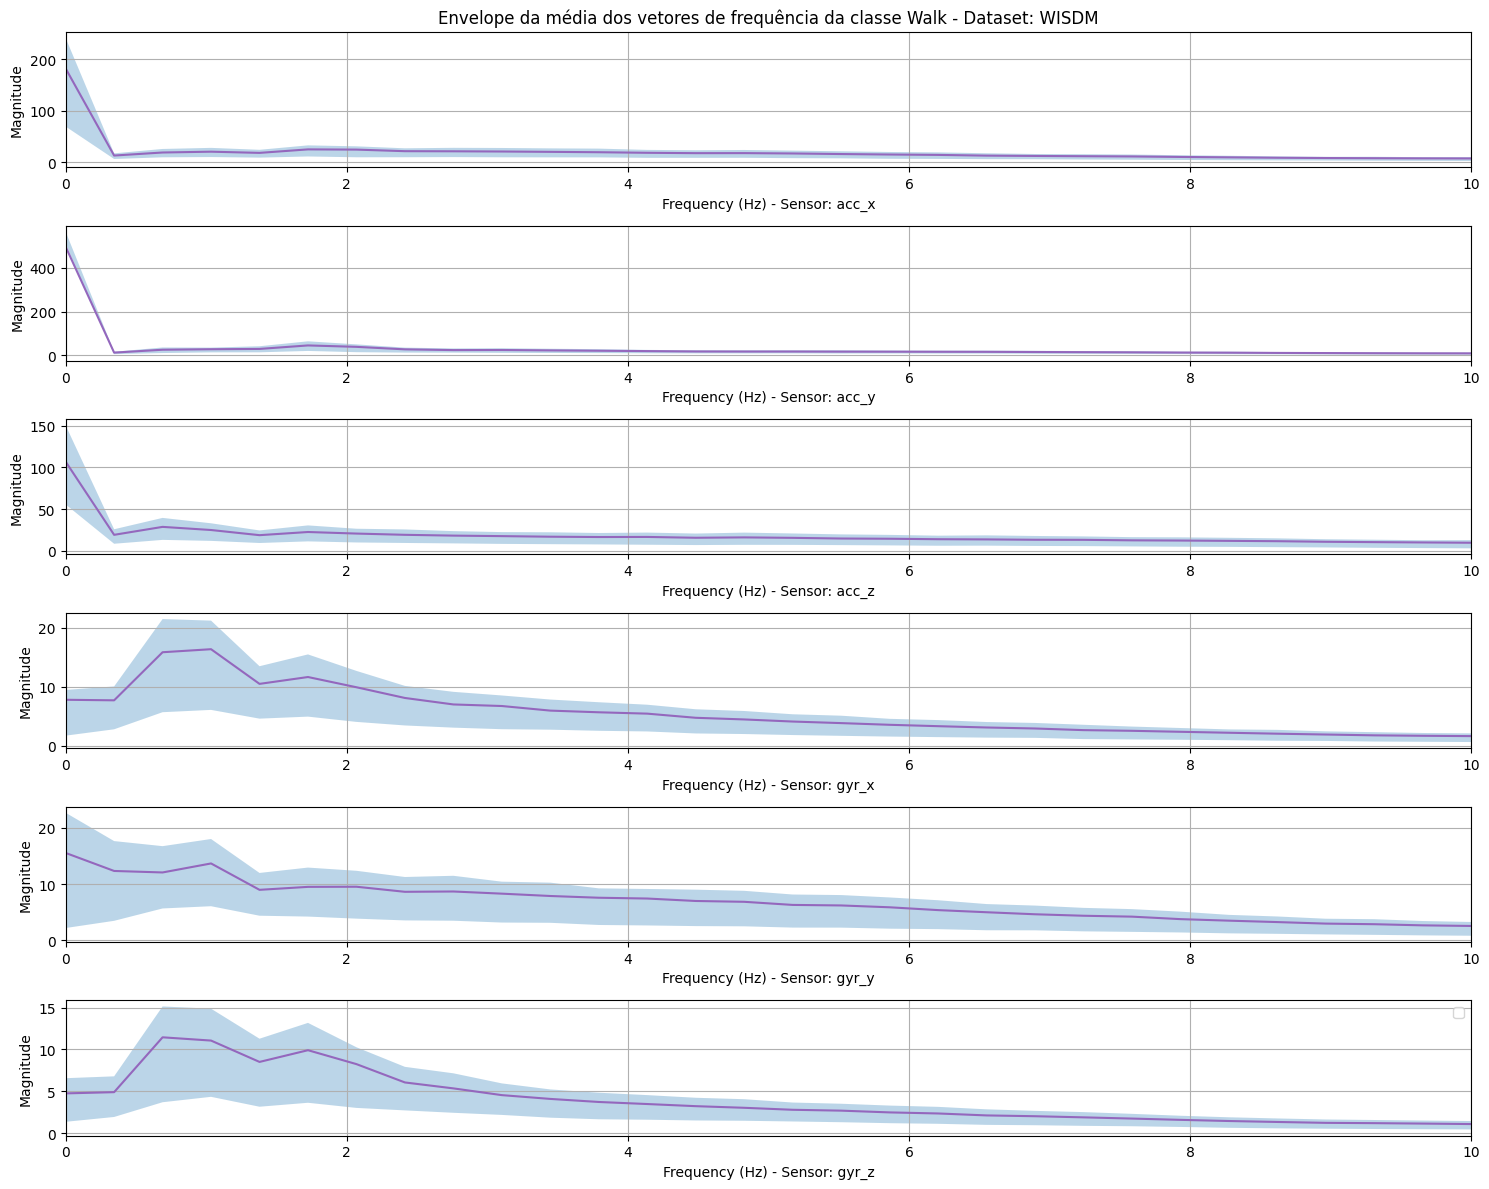

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


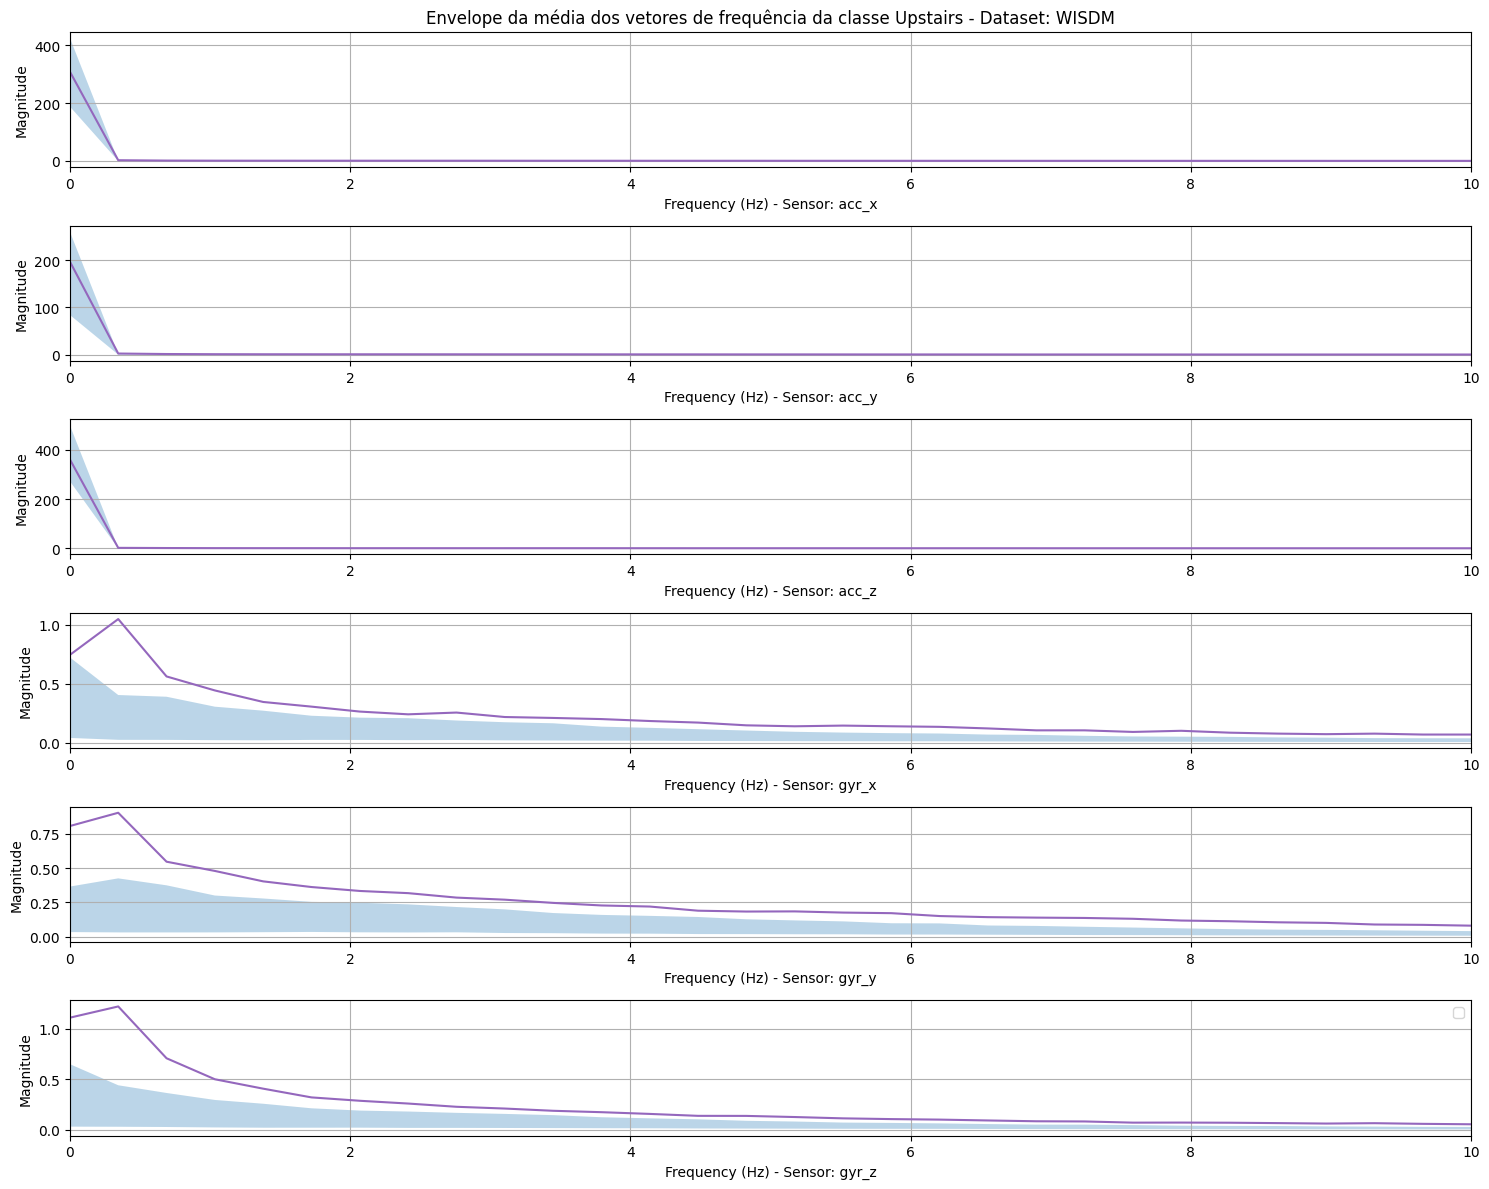

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


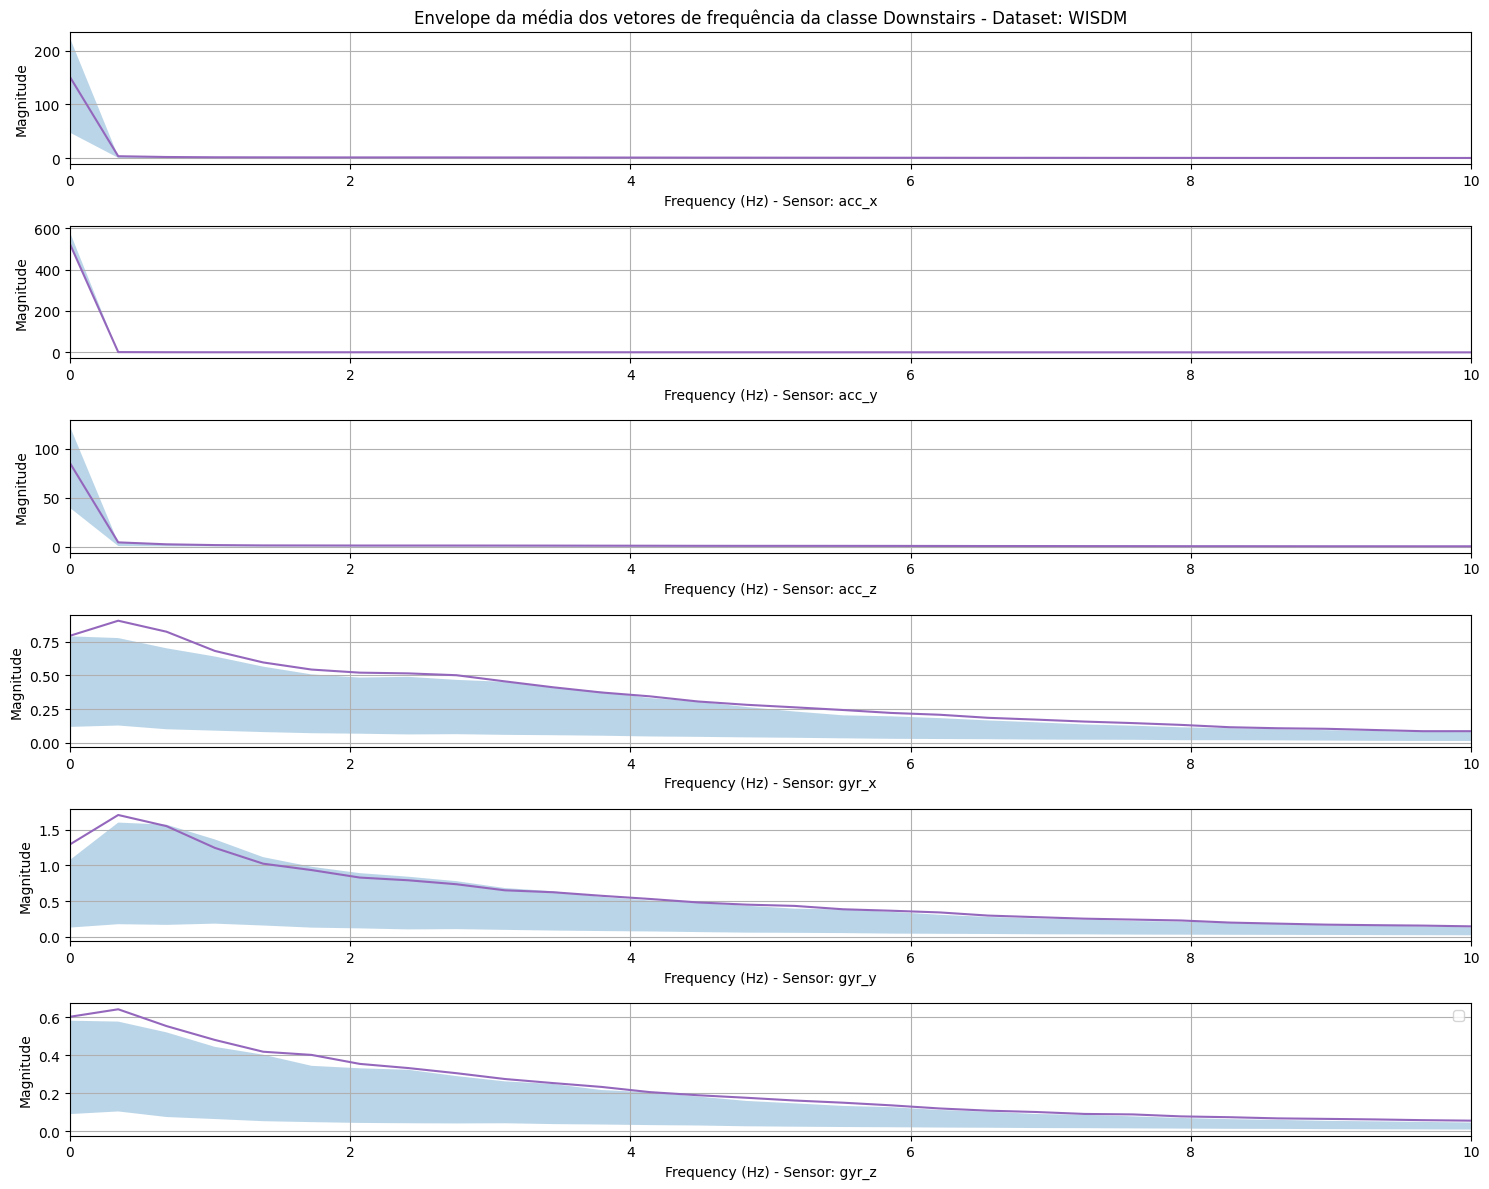

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


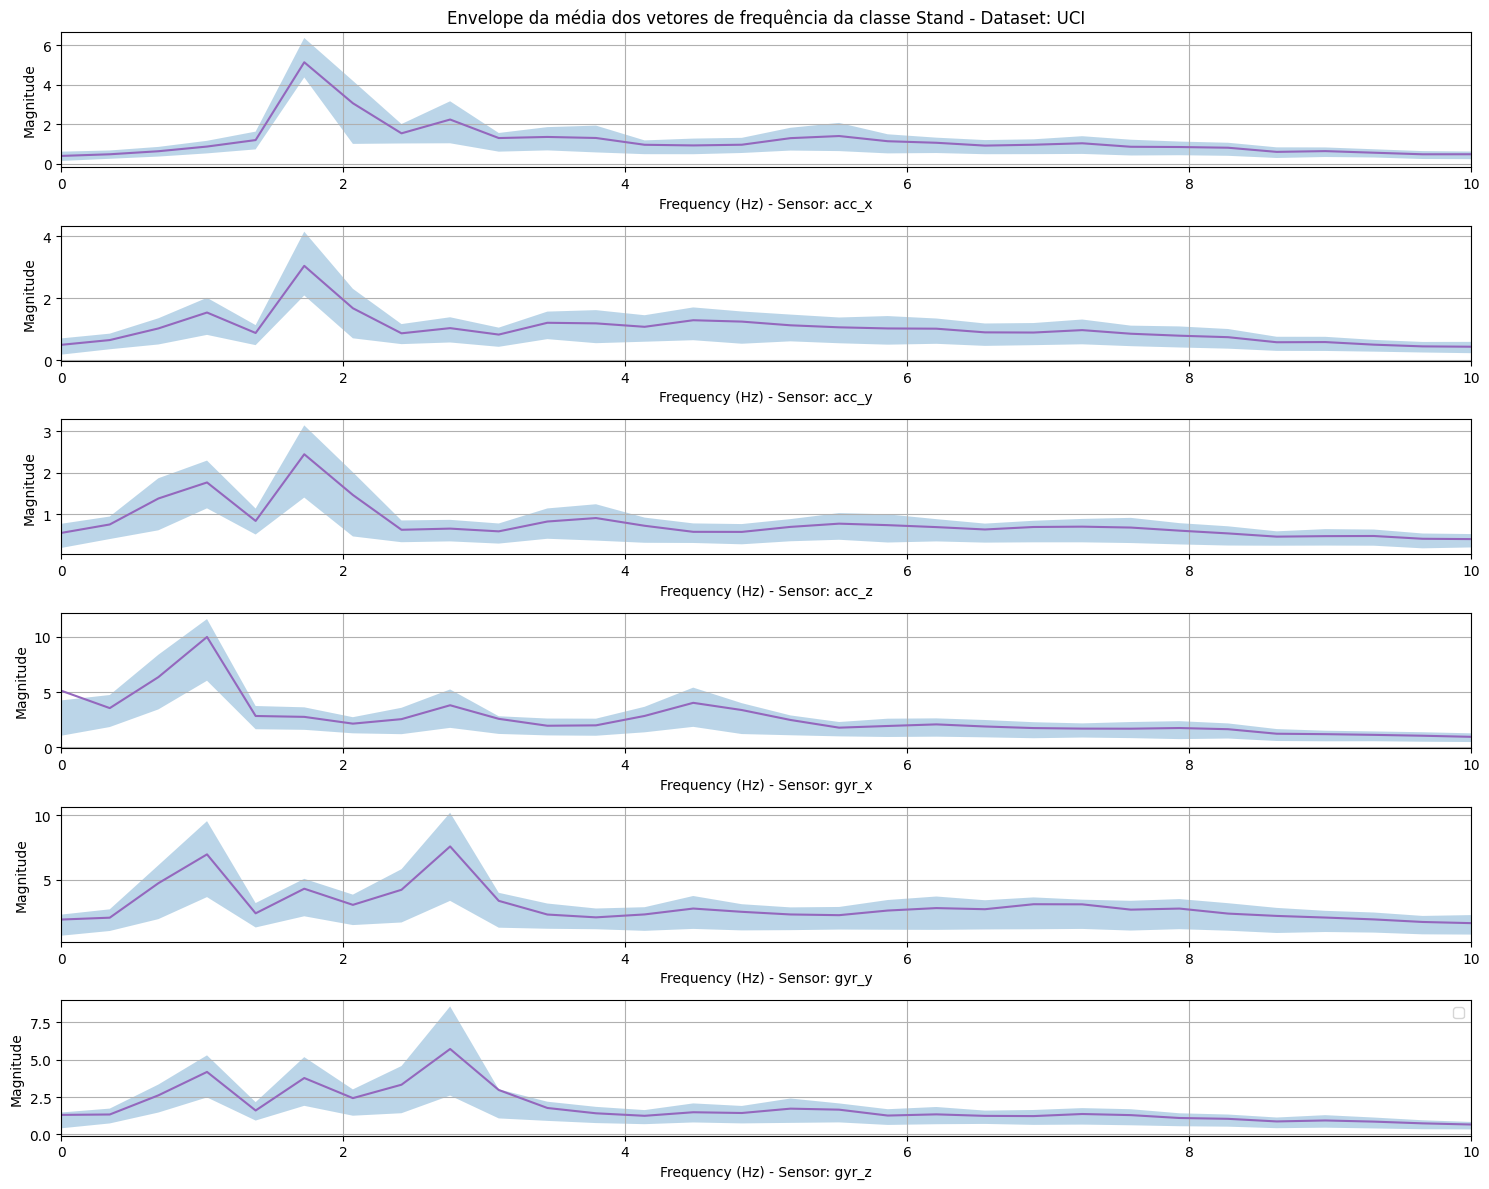

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


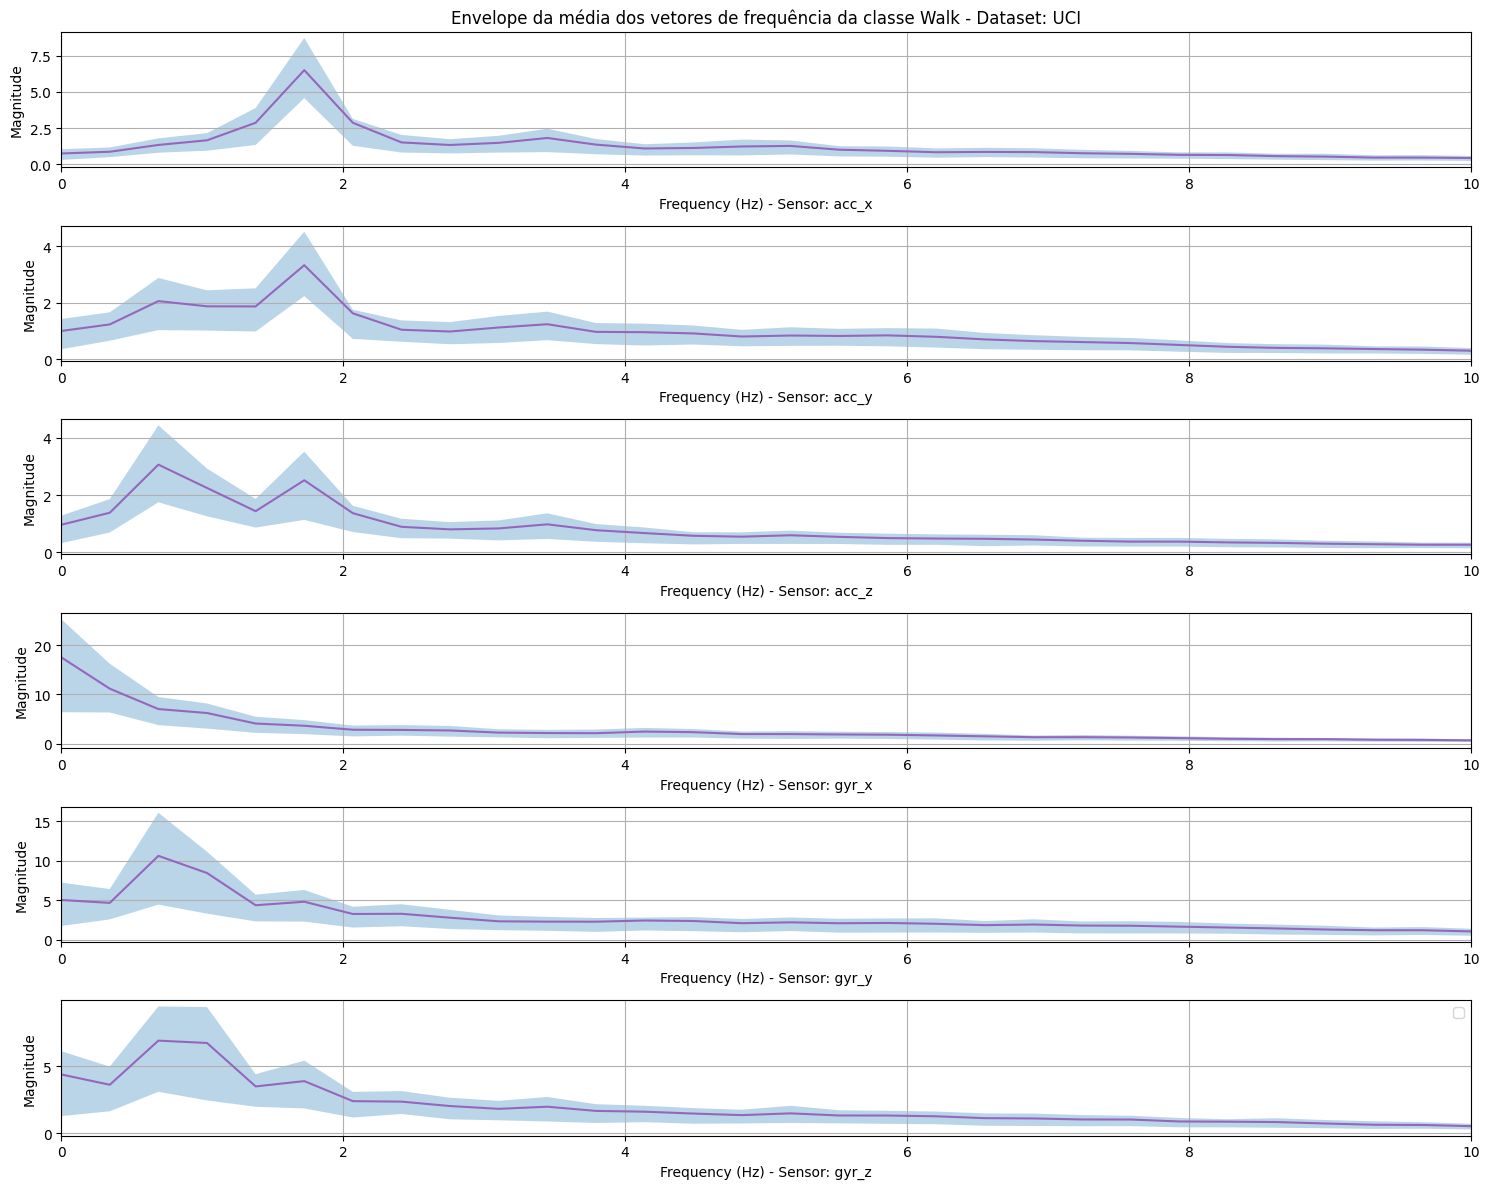

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


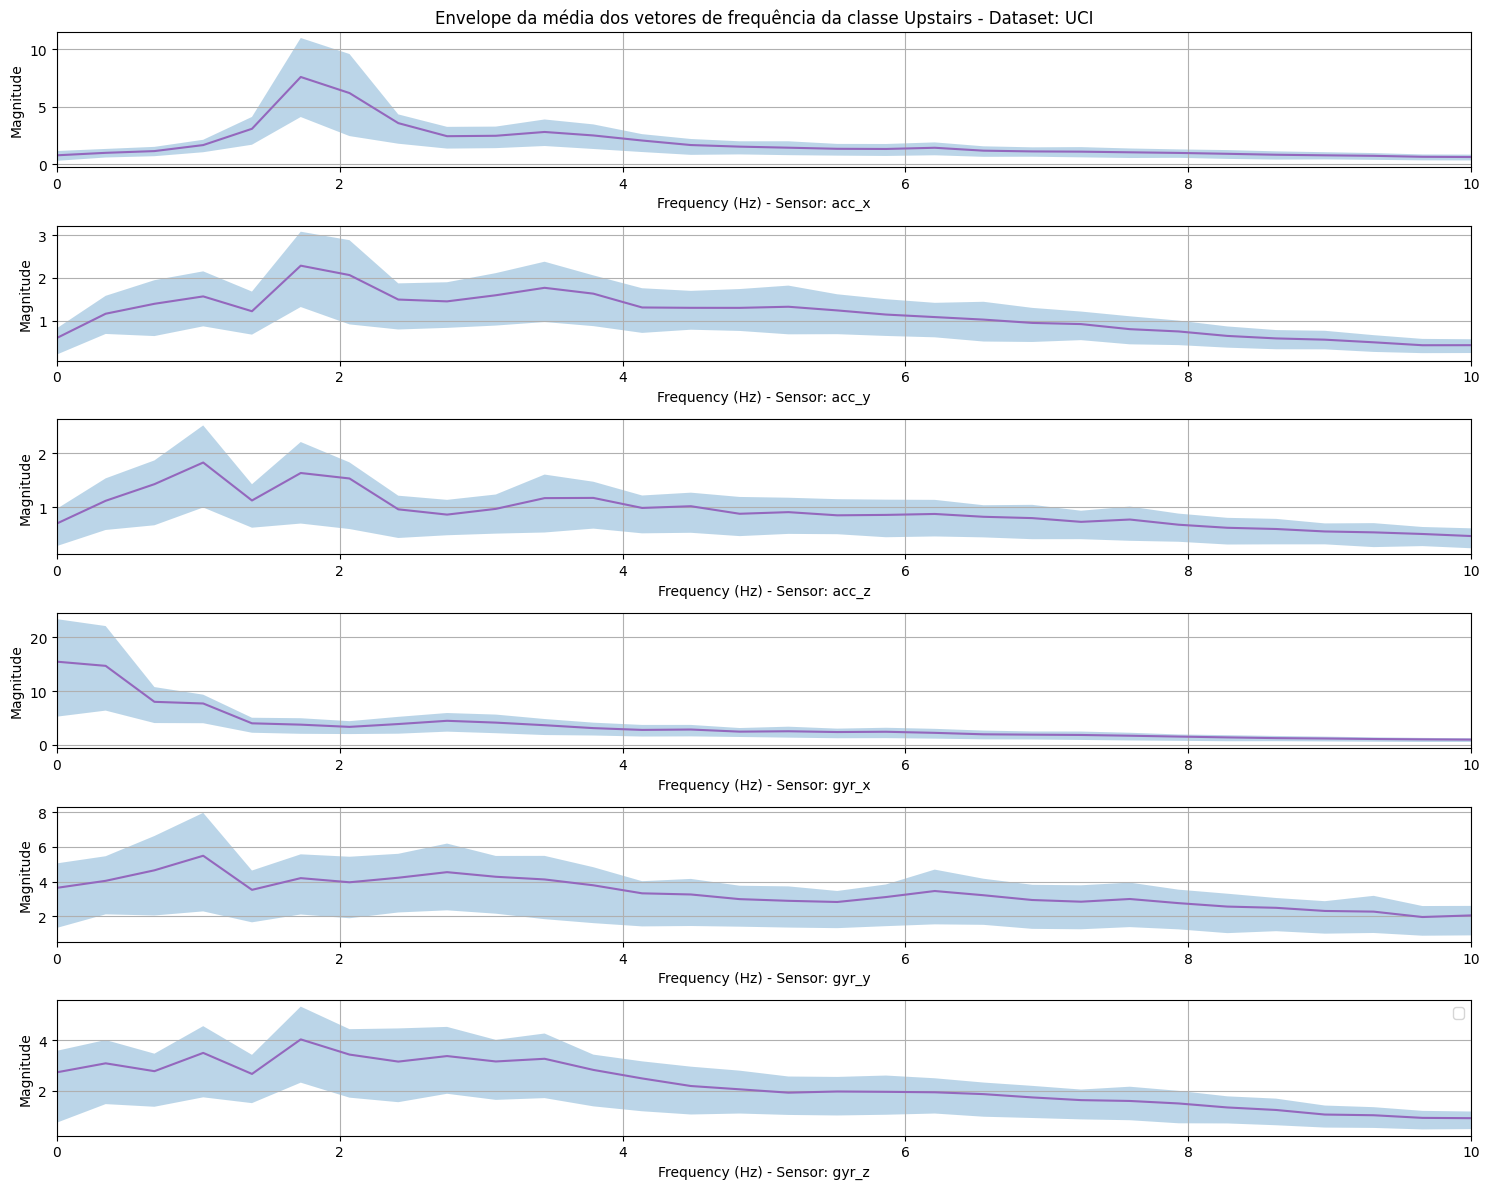

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


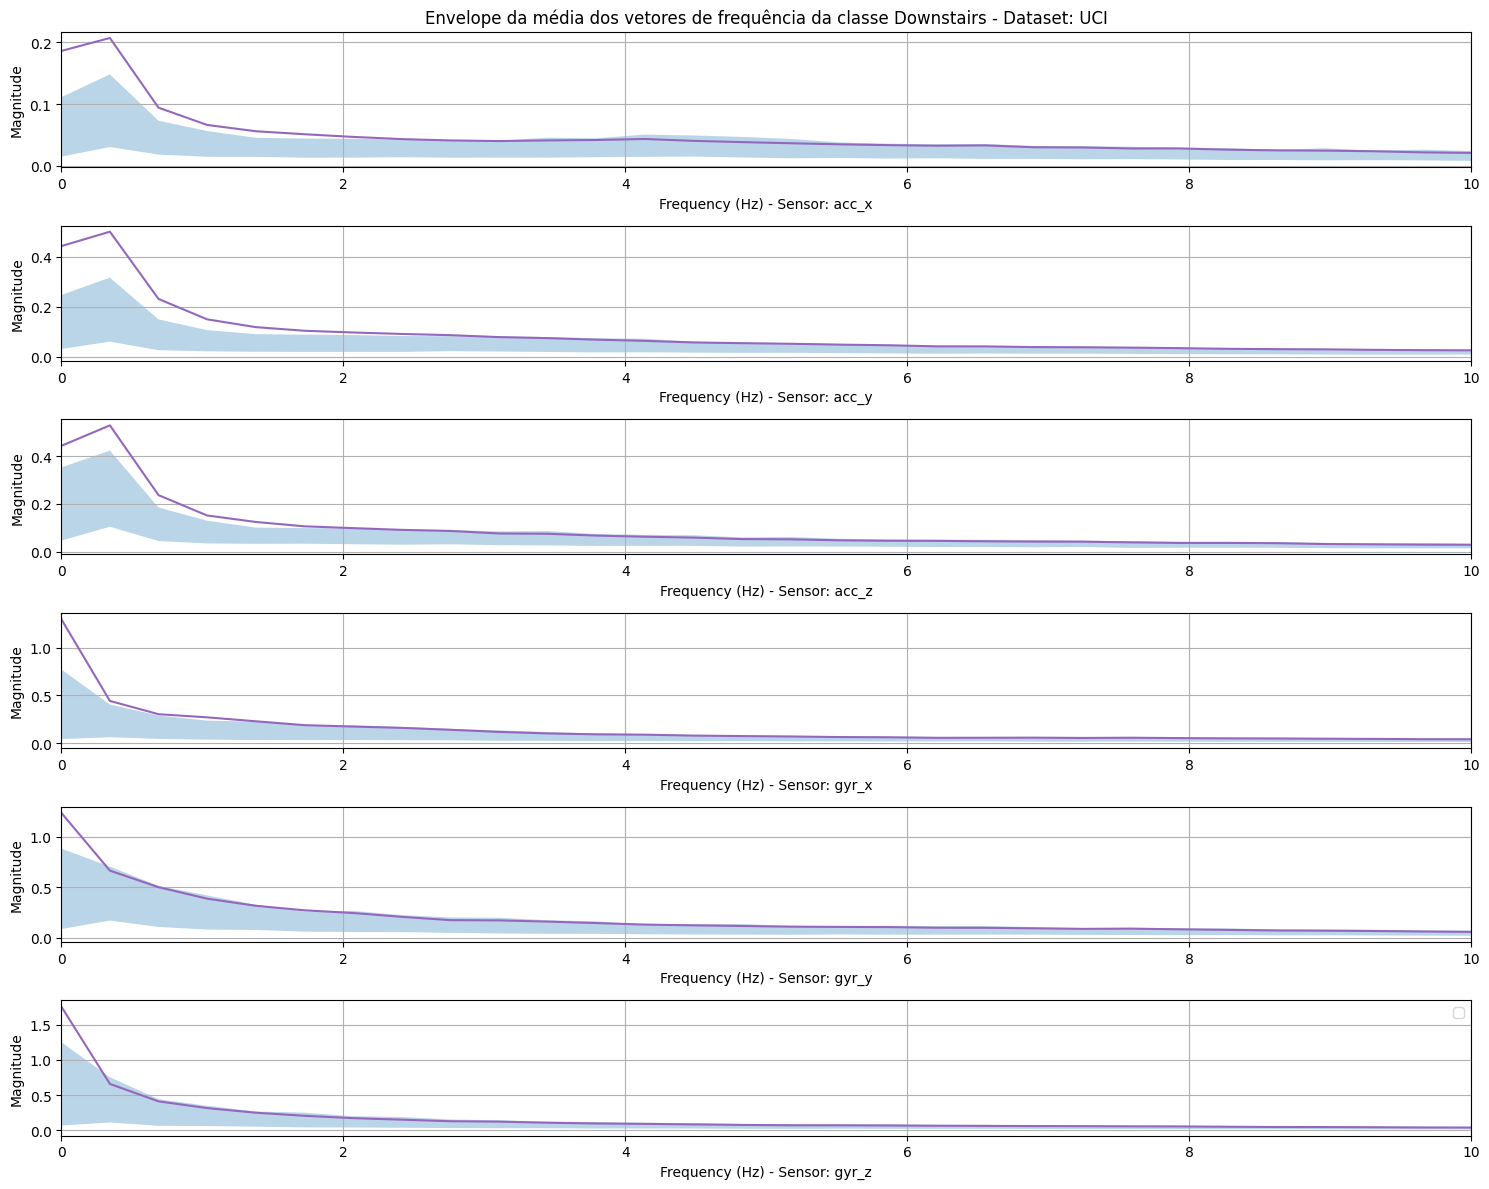

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


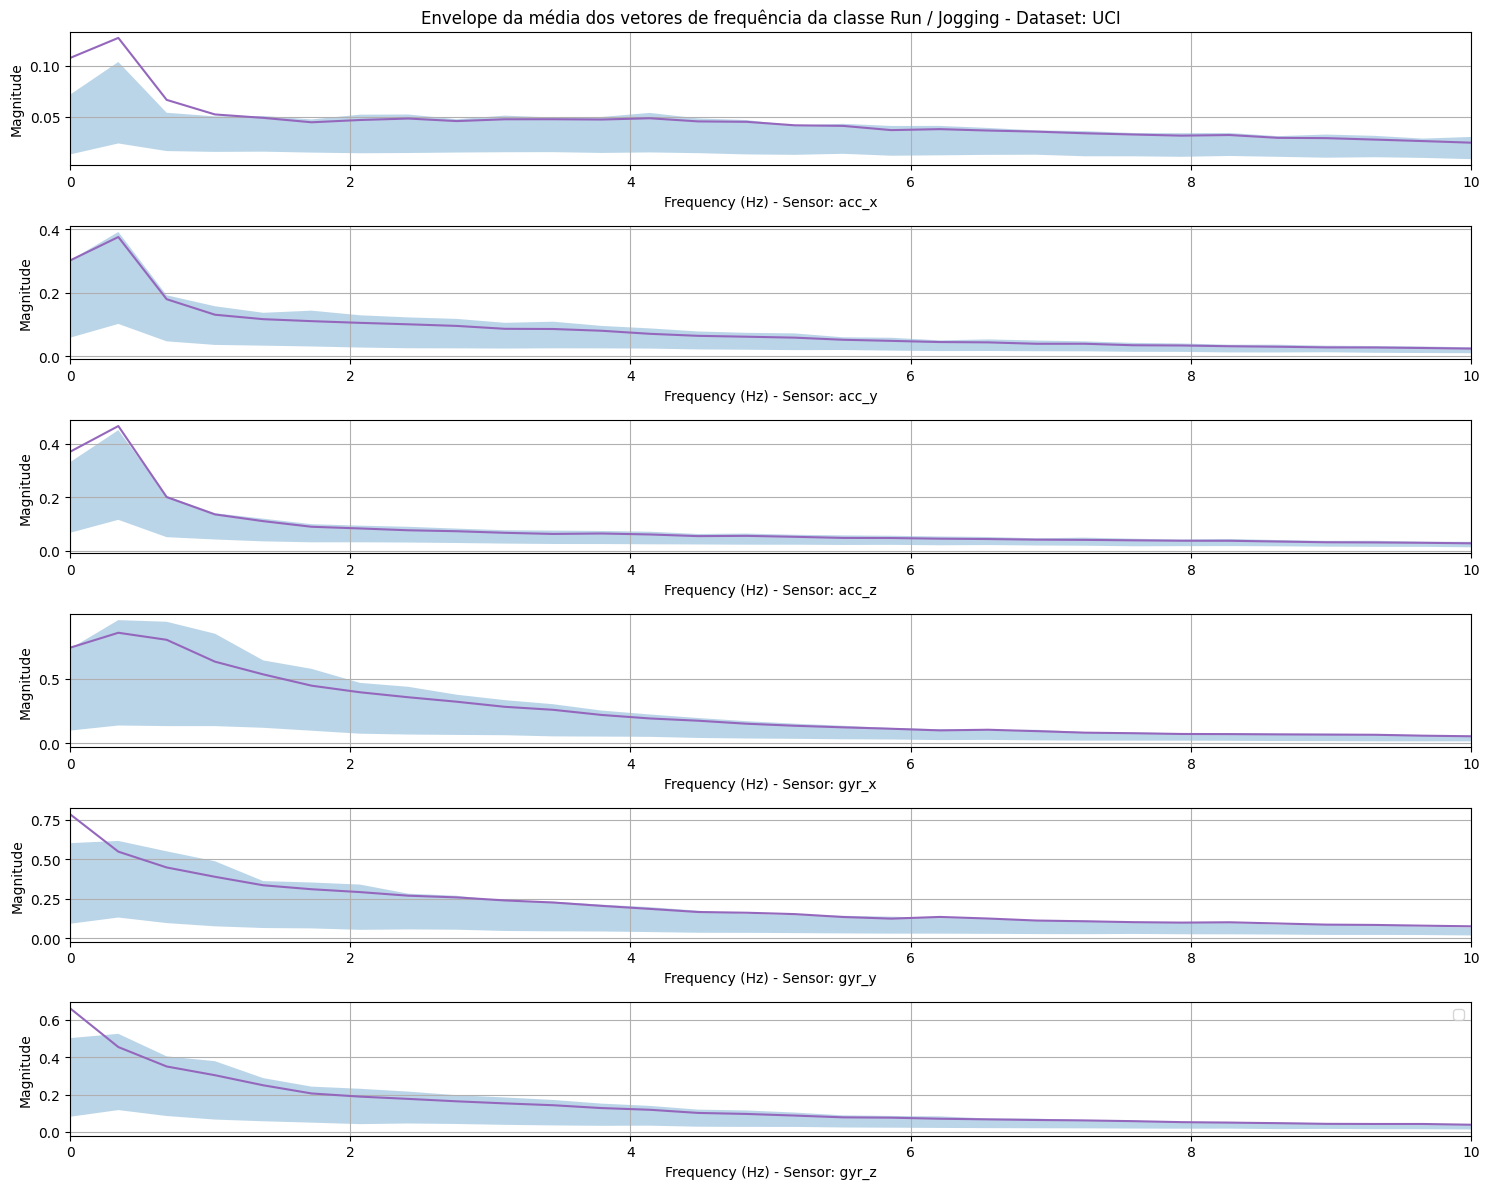

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


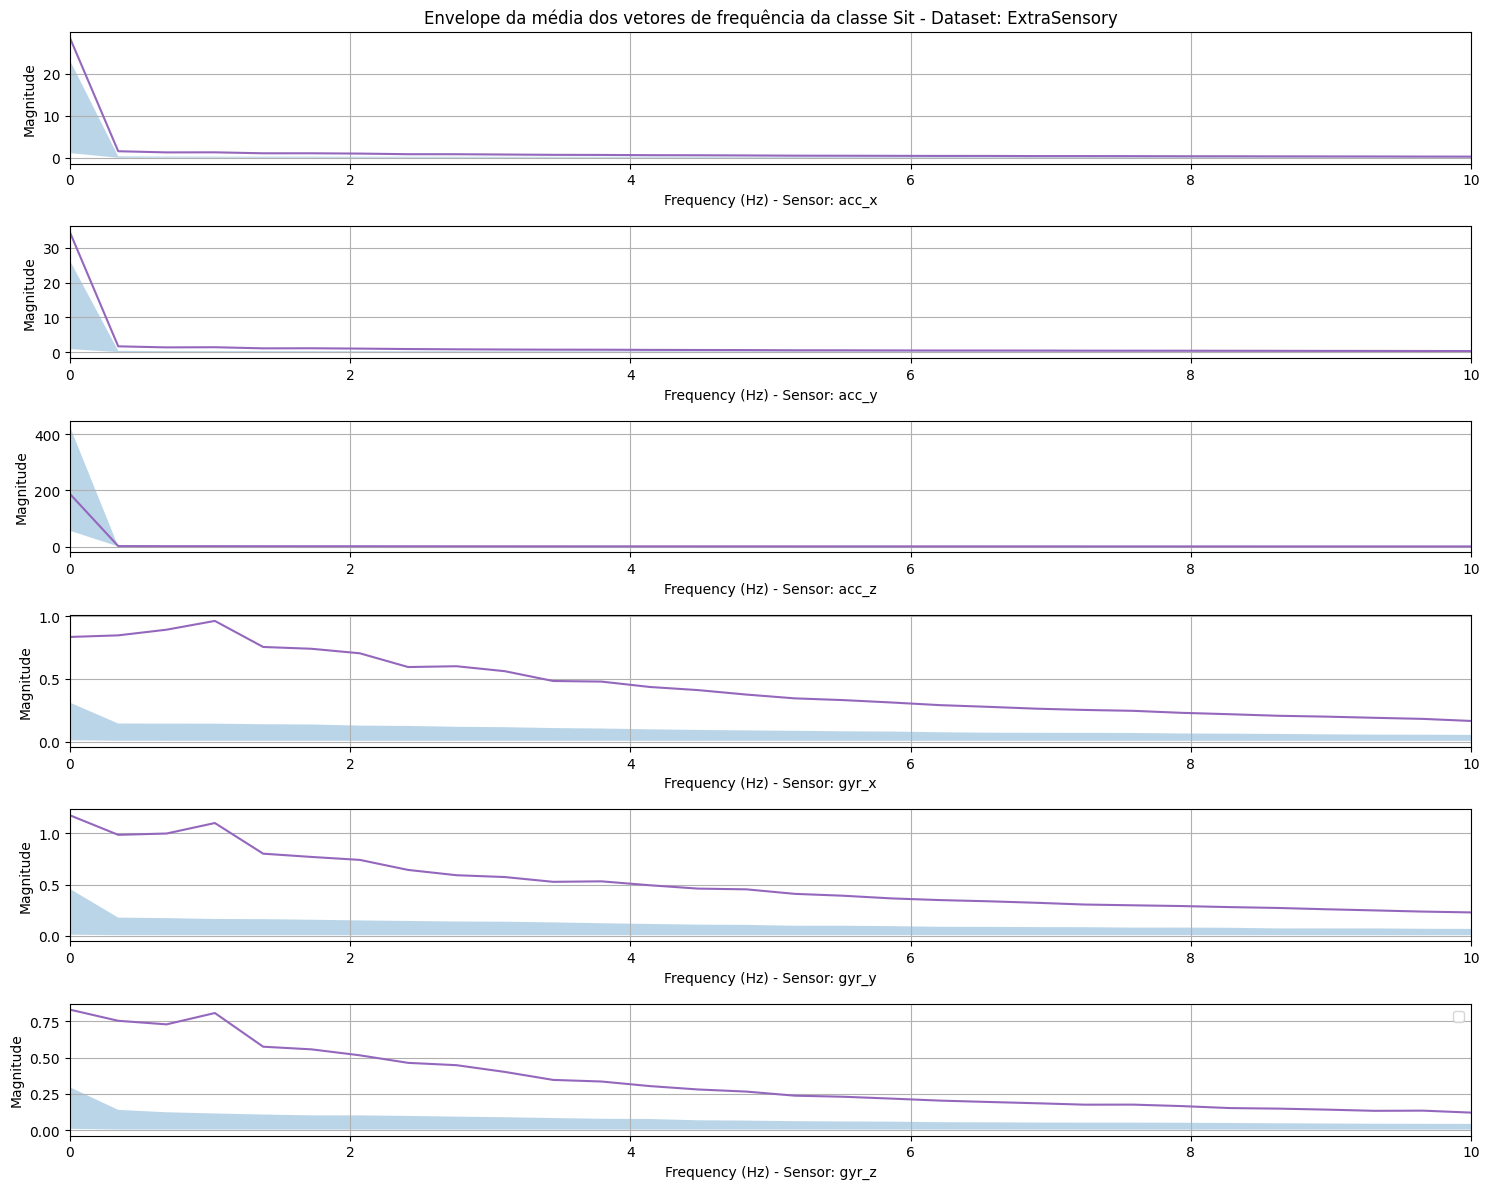

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


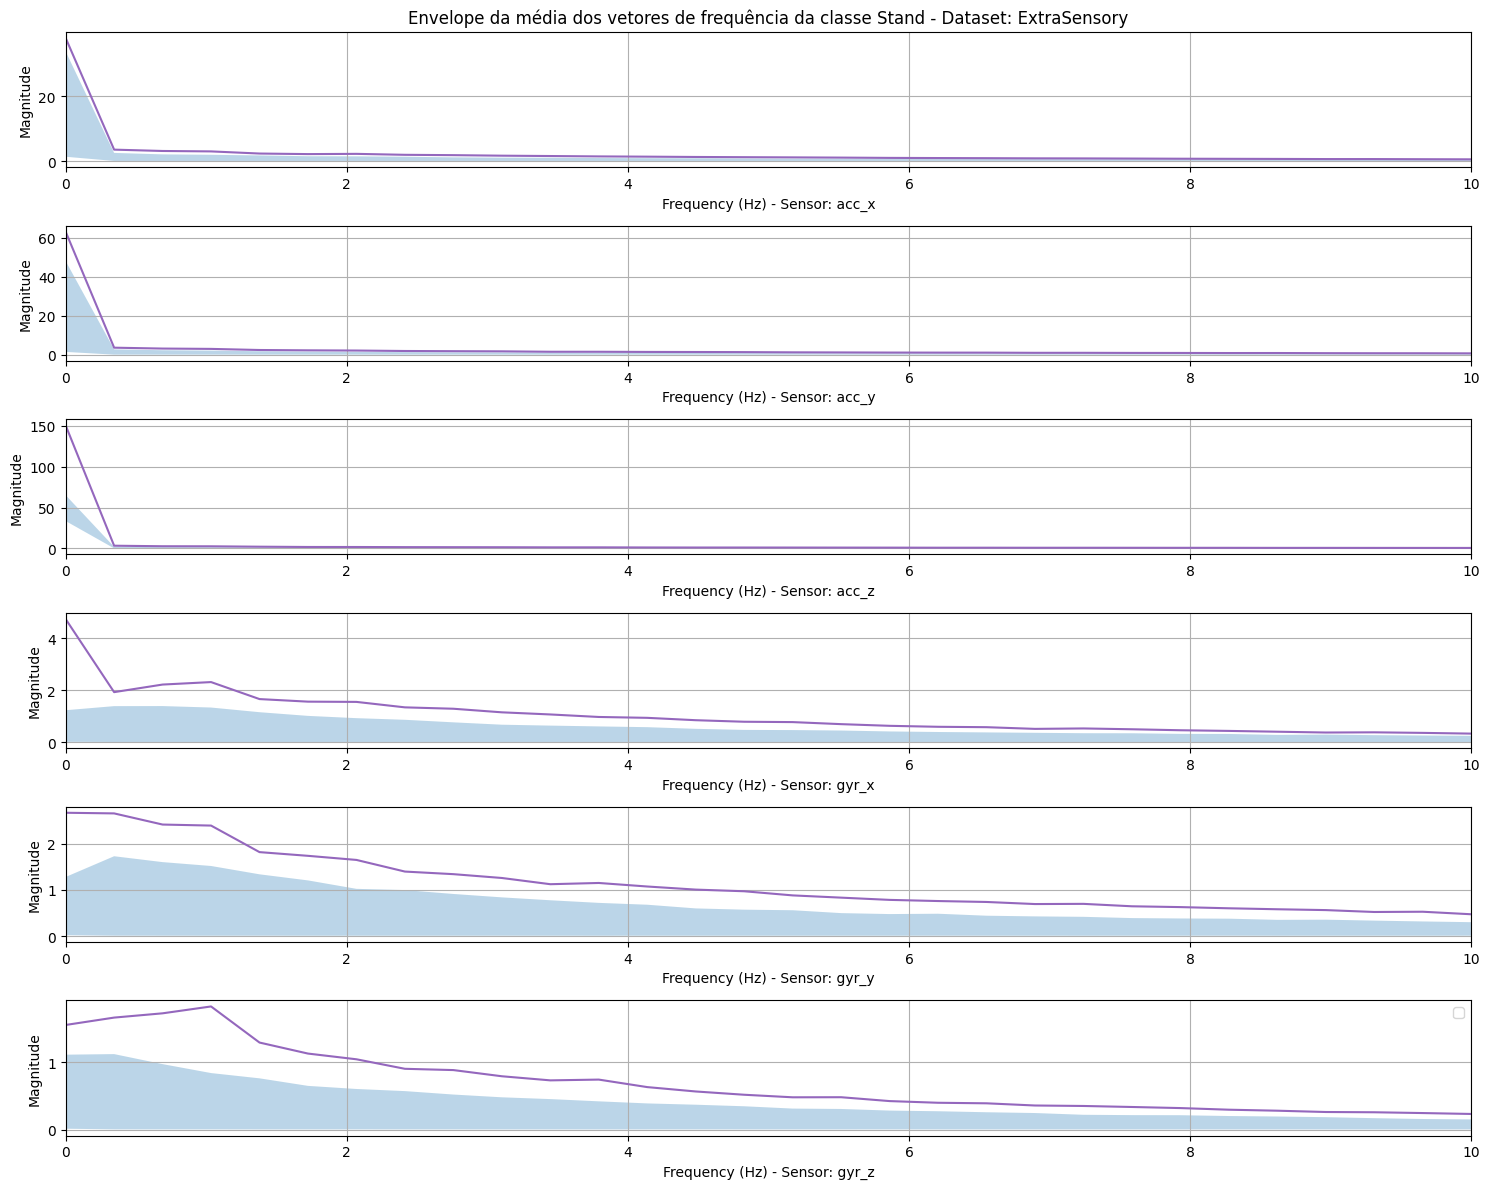

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


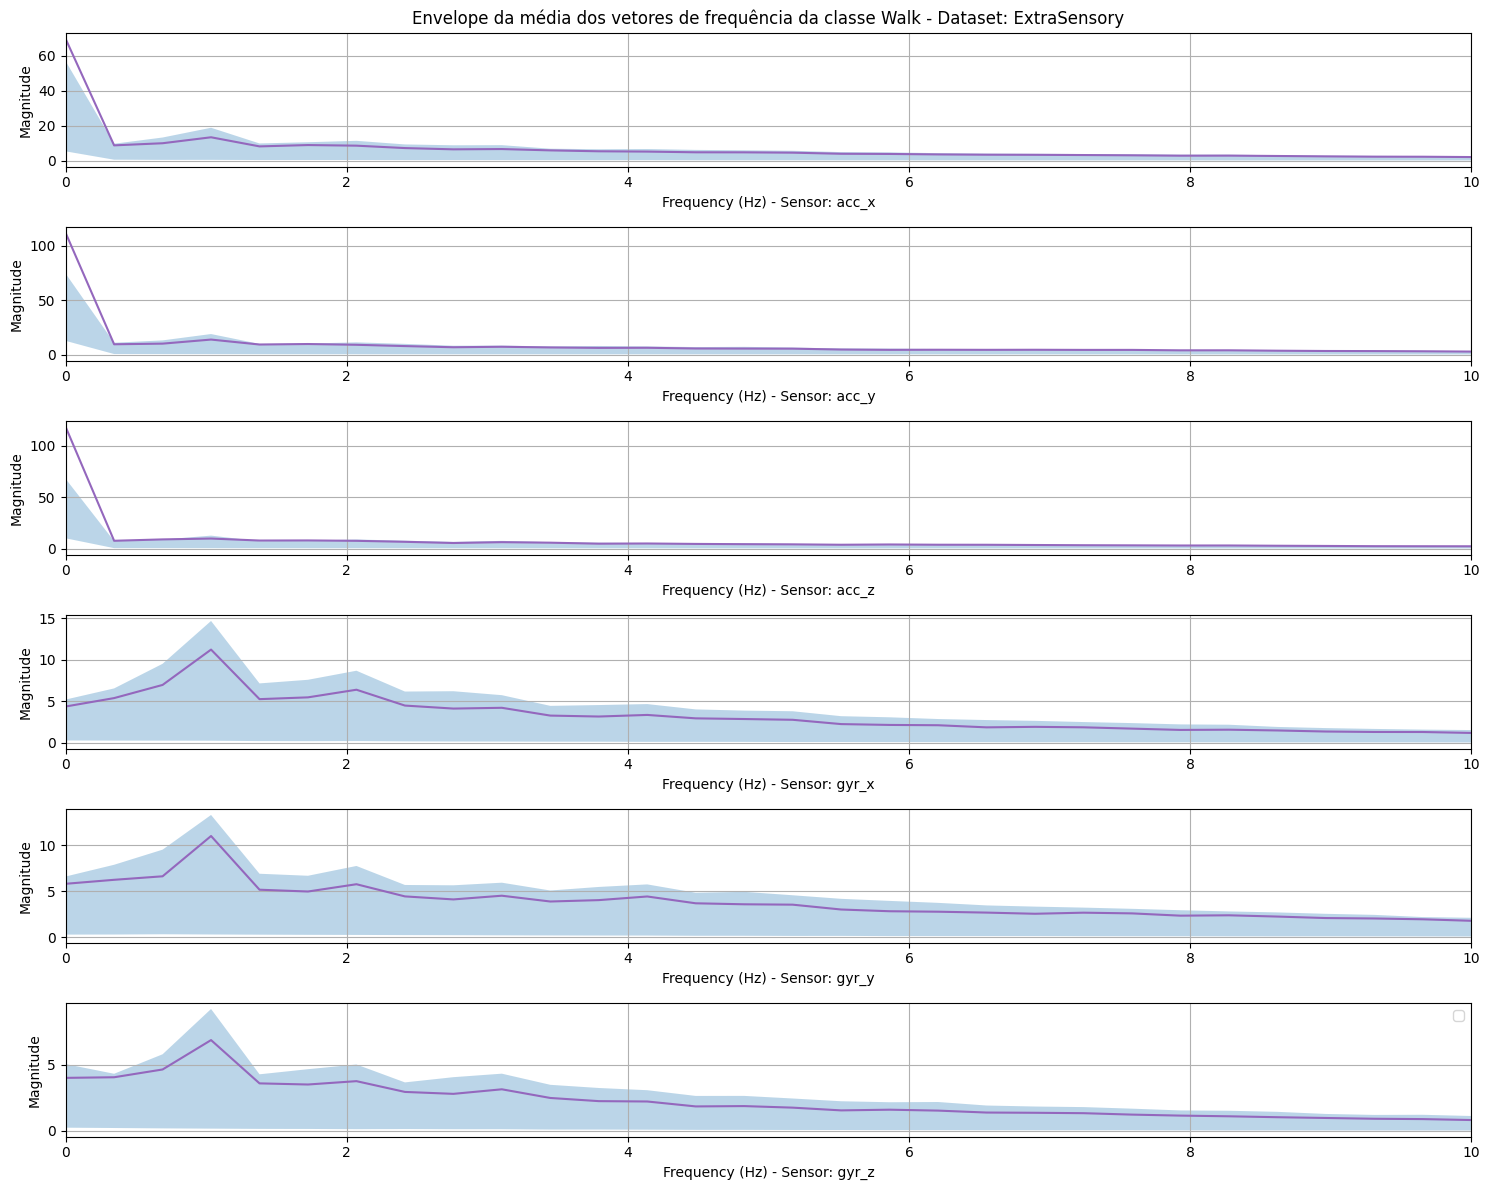

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


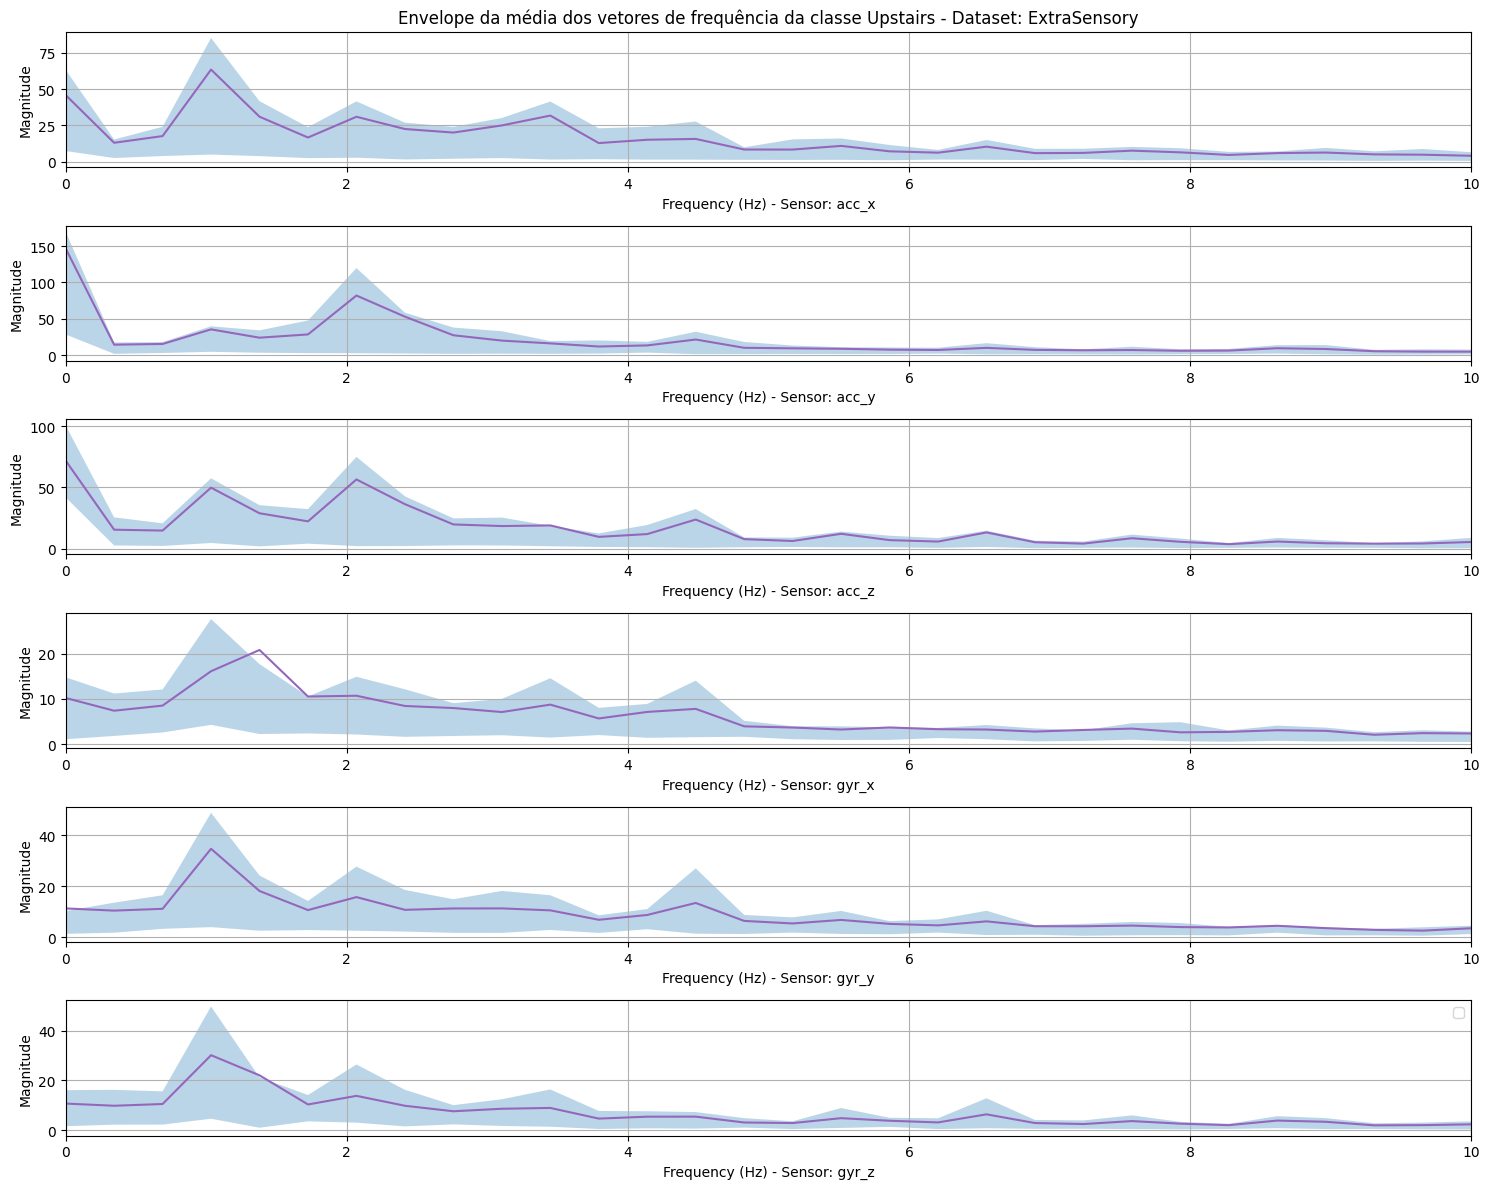

In [33]:
datasets = {'K': 'KuHar', 
            'M': 'MotionSense',
            'C': 'CHARM',
            'E': 'ExtraSensory', 
            'W': 'WISDM', 
            'U': 'UCI'
}

# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

for dataset in data["Id Dataset"].unique():

    data_new = data[data["Id Dataset"].isin([dataset])]

    # Creating the datasets

    # Train
    train = PandasMultiModalDataset(
        data_new,
        feature_prefixes=features,
        label_columns="normalized activity code",
        as_array=True
    )
    data_fft = transformer(train)
    plot(data_fft, dataset, classes_names, datasets)